In [1]:
import numpy as np
import pandas as pd

from plotly.subplots import make_subplots
import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
from tqdm.notebook import tqdm as tqdm

import plotly.graph_objs as go #visualization library
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf #autocorrelation test
import statsmodels.api as sm
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller #stationarity test
from statsmodels.tsa.statespace.sarimax import SARIMAX 
from datetime import datetime, timedelta
import statsmodels.api as sm
import gc
from pylab import rcParams
import random
import os
import time
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import gc
import lightgbm as lgb
import time
import numpy as np
import pandas as pd
import os
import time
import matplotlib.dates as mdates
import gc
import lightgbm as lgb
import time
import plotly.express as px
import plotly.graph_objects as go
from matplotlib.gridspec import GridSpec
#from fbprophet import Prophet
#from fbprophet.plot import plot_plotly, plot_components_plotly, add_changepoints_to_plot

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler

from xgboost import XGBRegressor
import multiprocessing as mp
import warnings
warnings.filterwarnings("ignore")
import datetime

%matplotlib inline

#from sklearn.metrics import mean_squared_error
#from statsmodels.tsa.seasonal import seasonal_decompose
#import statsmodels.api as sm
#import calendar

In [2]:
#pip install fbprophet

In [3]:
import plotly.io as pio
pio.templates["draft"] = go.layout.Template(
    layout_annotations=[
        dict(
            textangle=-30,
            opacity=0.1,
            font=dict(color="black", size=100),
            xref="paper",
            yref="paper",
            x=0.5,
            y=0.5,
            showarrow=False,
        )
    ]
)
pio.templates.default = "draft"

In [4]:
path = 'm5-forecasting-accuracy/'

In [5]:
train_sales = pd.read_csv(path+'sales_train_validation.csv')
calendar = pd.read_csv(path+'calendar.csv')
sell_prices = pd.read_csv(path+'sell_prices.csv')

In [6]:
train_sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30490 entries, 0 to 30489
Columns: 1919 entries, id to d_1913
dtypes: int64(1913), object(6)
memory usage: 446.4+ MB


In [7]:
# d_1, d_2, …, d_i, … d_1941: The number of units sold at day i, starting from 2011-01-29 to 2016-06-19.

train_sales

id        item_id    dept_id   cat_id  \
0      HOBBIES_1_001_CA_1_validation  HOBBIES_1_001  HOBBIES_1  HOBBIES   
1      HOBBIES_1_002_CA_1_validation  HOBBIES_1_002  HOBBIES_1  HOBBIES   
2      HOBBIES_1_003_CA_1_validation  HOBBIES_1_003  HOBBIES_1  HOBBIES   
3      HOBBIES_1_004_CA_1_validation  HOBBIES_1_004  HOBBIES_1  HOBBIES   
4      HOBBIES_1_005_CA_1_validation  HOBBIES_1_005  HOBBIES_1  HOBBIES   
...                              ...            ...        ...      ...   
30485    FOODS_3_823_WI_3_validation    FOODS_3_823    FOODS_3    FOODS   
30486    FOODS_3_824_WI_3_validation    FOODS_3_824    FOODS_3    FOODS   
30487    FOODS_3_825_WI_3_validation    FOODS_3_825    FOODS_3    FOODS   
30488    FOODS_3_826_WI_3_validation    FOODS_3_826    FOODS_3    FOODS   
30489    FOODS_3_827_WI_3_validation    FOODS_3_827    FOODS_3    FOODS   

      store_id state_id  d_1  d_2  d_3  d_4  ...  d_1904  d_1905  d_1906  \
0         CA_1       CA    0    0    0    0  ...       1       3       0   
1         CA_1       CA    0    0    0    0  ...       0       0       0   
2         CA_1       CA    0    0    0    0  ...       2       1       2   
3         CA_1       CA    0    0    0    0  ...       1       0       5   
4         CA_1       CA    0    0    0    0  ...       2       1       1   
...        ...      ...  ...  ...  ...  ...  ...     ...     ...     ...   
30485     WI_3       WI    0    0    2    2  ...       2       0       0   
30486     WI_3       WI    0    0    0    0  ...       0       0       0   
30487     WI_3       WI    0    6    0    2  ...       2       1       0   
30488     WI_3       WI    0    0    0    0  ...       0       0       1   
30489     WI_3       WI    0    0    0    0  ...       0       0       0   

       d_1907  d_1908  d_1909  d_1910  d_1911  d_1912  d_1913  
0           1       1       1       3       0       1       1  
1           0       0       1       0       0       0       0  
2           1       1       1       0       1       1       1  
3           4       1       0       1       3       7       2  
4           0       1       1       2       2       2       4  
...       ...     ...     ...     ...     ...     ...     ...  
30485       0       0       0       1       0       0       1  
30486       0       0       0       0       0       1       0  
30487       2       0       1       0       0       1       0  
30488       0       0       1       0       3       1       3  
30489       0       0       0       0       0       0       0  

[30490 rows x 1919 columns]

In [8]:
train_sales.isnull().sum().sort_values(ascending = False)

id        0
d_1270    0
d_1282    0
d_1281    0
d_1280    0
         ..
d_630     0
d_629     0
d_628     0
d_627     0
d_1913    0
Length: 1919, dtype: int64

In [9]:
states = train_sales.state_id.unique().tolist()

In [10]:
states

['CA', 'TX', 'WI']

In [11]:
stores = train_sales.store_id.unique().tolist()

In [12]:
stores

['CA_1',
 'CA_2',
 'CA_3',
 'CA_4',
 'TX_1',
 'TX_2',
 'TX_3',
 'WI_1',
 'WI_2',
 'WI_3']

In [13]:
categories = train_sales.cat_id.unique().tolist()

In [14]:
categories

['HOBBIES', 'HOUSEHOLD', 'FOODS']

In [15]:
items = train_sales.dept_id.unique().tolist()

In [16]:
items

['HOBBIES_1',
 'HOBBIES_2',
 'HOUSEHOLD_1',
 'HOUSEHOLD_2',
 'FOODS_1',
 'FOODS_2',
 'FOODS_3']

In [17]:
print(f'There are {len(train_sales.item_id.unique())} Items in the Dataset')

There are 3049 Items in the Dataset


In [20]:
import datetime
x = datetime.date(2011,1,29)
for c in ((train_sales.columns)[6:]):
    train_sales.rename(columns={c:x},inplace=True)
    x = x + datetime.timedelta(days=1)

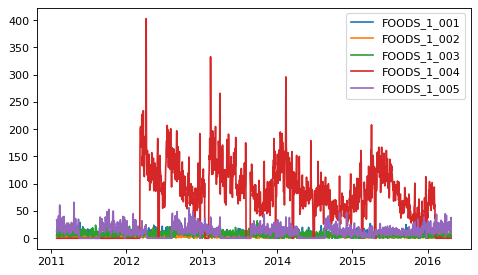

In [21]:
# Sales of first 5 items as time series

X = train_sales.groupby('item_id')[(train_sales.columns)[6:]].sum()

plt.figure(num=None, figsize=(7, 4), dpi=80, facecolor='w', edgecolor='k')
for i in range(5):
    plt.plot(X.iloc[i,:],label=X.index[i])
    plt.legend(loc='best')
plt.show()

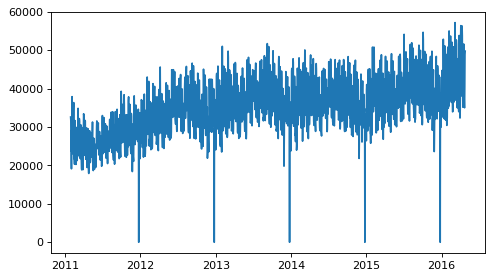

In [23]:
# Total sales as time series

plt.figure(num=None, figsize=(7, 4), dpi=80, facecolor='w', edgecolor='k')
(X.sum()).plot()
plt.show()

In [26]:
# Monthly sales in different cities

X = train_sales
X = X.groupby(X.columns.map(lambda x : x if type(x) == str else x.strftime('%Y-%m')),axis=1).sum()
for c in ((X.columns)[:-6]):
    x= datetime.datetime.strptime(c, '%Y-%m').date()
    X.rename(columns={c:x},inplace=True)

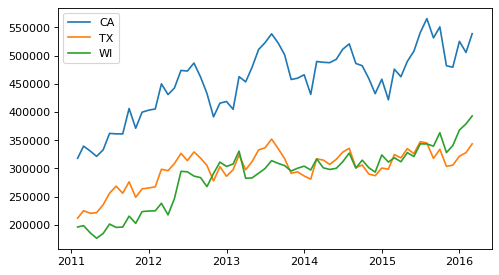

In [27]:
F = X.groupby(['state_id'])[(X.columns)[:-6]].sum()
plt.figure(num=None, figsize=(7, 4), dpi=80, facecolor='w', edgecolor='k')
for i in range(3):
    plt.plot(F.iloc[i,1:-1],label=F.index[i])
    plt.legend(loc='best')
plt.show()

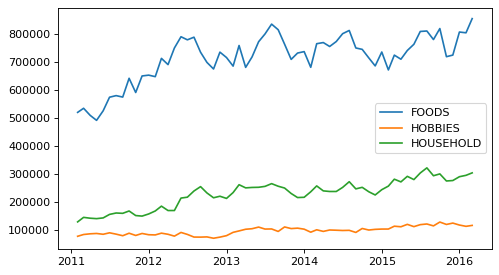

In [28]:
#Monthly sales at different categories


F = X.groupby(['cat_id'])[(X.columns)[:-6]].sum()
plt.figure(num=None, figsize=(7, 4), dpi=80, facecolor='w', edgecolor='k')
for i in range(3):
    plt.plot(F.iloc[i,1:-1],label=F.index[i])
    plt.legend(loc='best')
plt.show()

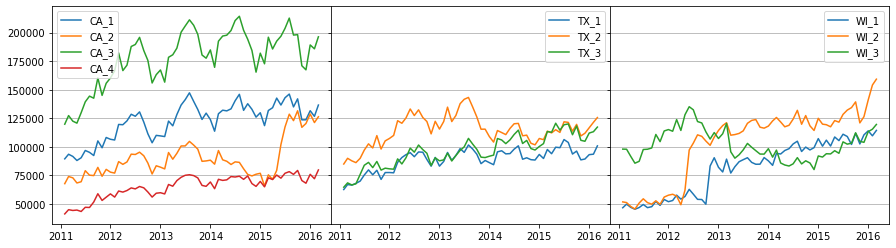

In [30]:
# Monthly sales at different stores

F = X.groupby(['store_id'])[(X.columns)[:-6]].sum()
fig, ax = plt.subplots(1, 3, sharey=True, figsize = (15,4))
for i in range(10):
    n = lambda x : 0 if x == 'C' else (1 if x == 'T' else 2)
    n = n(F.index[i][0])
    ax[n].plot(F.iloc[i,1:-1],label=F.index[i])
    ax[n].grid(b=True,axis='y')
    ax[n].legend(loc='best')
fig.subplots_adjust( wspace=0.0)
plt.show()

In [33]:
# smoothing with fit

F = train_sales.drop(labels=[datetime.date(2011, 12, 25),datetime.date(2012, 12, 25), datetime.date(2013, 12, 25),datetime.date(2014, 12, 25),datetime.date(2015, 12, 25)],axis=1)

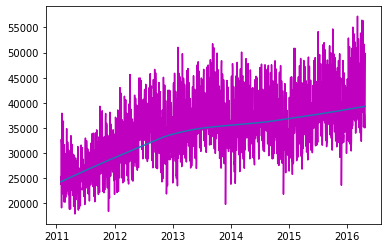

In [34]:
import statsmodels.api as sm
lowess = sm.nonparametric.lowess
S = F.iloc[:,6:].sum()
z = lowess(S.values, range(S.shape[0]))
plt.plot(S,color='m')
plt.plot(pd.Series(z[:,1],S.index))

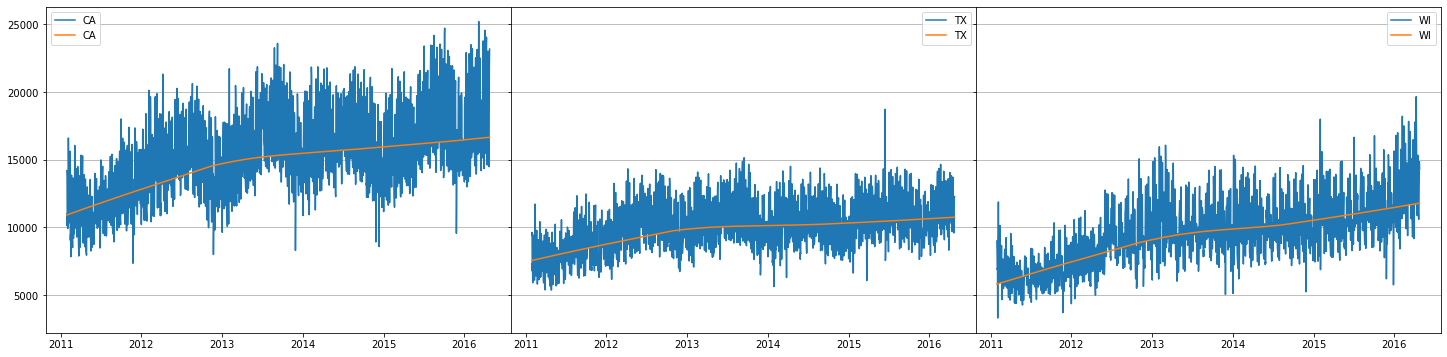

In [35]:
# sales per state with seasonality
M = F.groupby(['state_id'])[(F.columns)[6:]].sum()

fig, ax = plt.subplots(1, 3, sharey=True, figsize = (25,6))

for i in range(3):
    ax[i].plot(M.iloc[i,:],label=M.index[i])
    z = lowess(M.iloc[i,:].values, range(M.shape[1]))
    ax[i].plot(pd.Series(z[:,1],M.columns),label=M.index[i])
    ax[i].grid(b=True,axis='y')
    ax[i].legend(loc='best')

fig.subplots_adjust( wspace=0.0)
plt.show()

In [37]:
mean_sales = F.iloc[:,6:].sum().mean()

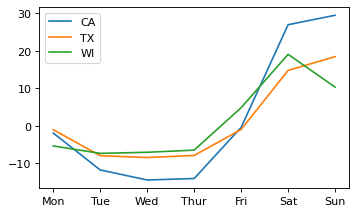

In [38]:
# weekly seasonality
A = M
for i in range(3):
    z = lowess(M.iloc[i,:].values, range(M.shape[1]))
    A.iloc[i,:] = M.iloc[i,:] - z[:,1]
A = A/mean_sales
A = A.groupby(A.columns.map(lambda x : str(x.weekday())),axis=1).sum()
plt.figure(num=None, figsize=(5, 3), dpi=80, facecolor='w', edgecolor='k')
for i in range(3):
    plt.plot(A.iloc[i,:],label=A.index[i])
    plt.xticks(range(0,7),['Mon', 'Tue', 'Wed', 'Thur', 'Fri','Sat','Sun' ])
    plt.legend(loc='best')
plt.show()

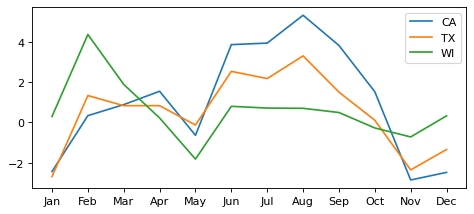

In [39]:
# monthly seasonality
A = M
for i in range(3):
    z = lowess(M.iloc[i,:].values, range(M.shape[1]))
    A.iloc[i,:] = M.iloc[i,:] - z[:,1]
A = A/mean_sales
A = A.groupby(A.columns.map(lambda x : (x.month)),axis=1).sum()
plt.figure(num=None, figsize=(7,3), dpi=80, facecolor='w', edgecolor='k')
for i in range(3):
    plt.plot(A.iloc[i,:],label=A.index[i])
    plt.legend(loc='best')
    plt.xticks(range(1,13),['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.show()

In [17]:
#date: The date in a “y-m-d” format.

# wm_yr_wk: The id of the week the date belongs to.

# weekday: The type of the day (Saturday, Sunday, …, Friday).

# wday: The id of the weekday, starting from Saturday.

# month: The month of the date.

# year: The year of the date.
# snap_CA, snap_TX, and snap_WI: A binary variable (0 or 1) indicating whether the stores of CA, TX or WI allow SNAP3 purchases on the examined date. 1 indicates that SNAP purchases are allowed.
calendar

date  wm_yr_wk    weekday  wday  month  year       d  \
0     2011-01-29     11101   Saturday     1      1  2011     d_1   
1     2011-01-30     11101     Sunday     2      1  2011     d_2   
2     2011-01-31     11101     Monday     3      1  2011     d_3   
3     2011-02-01     11101    Tuesday     4      2  2011     d_4   
4     2011-02-02     11101  Wednesday     5      2  2011     d_5   
...          ...       ...        ...   ...    ...   ...     ...   
1964  2016-06-15     11620  Wednesday     5      6  2016  d_1965   
1965  2016-06-16     11620   Thursday     6      6  2016  d_1966   
1966  2016-06-17     11620     Friday     7      6  2016  d_1967   
1967  2016-06-18     11621   Saturday     1      6  2016  d_1968   
1968  2016-06-19     11621     Sunday     2      6  2016  d_1969   

      event_name_1 event_type_1  event_name_2 event_type_2  snap_CA  snap_TX  \
0              NaN          NaN           NaN          NaN        0        0   
1              NaN          NaN           NaN          NaN        0        0   
2              NaN          NaN           NaN          NaN        0        0   
3              NaN          NaN           NaN          NaN        1        1   
4              NaN          NaN           NaN          NaN        1        0   
...            ...          ...           ...          ...      ...      ...   
1964           NaN          NaN           NaN          NaN        0        1   
1965           NaN          NaN           NaN          NaN        0        0   
1966           NaN          NaN           NaN          NaN        0        0   
1967           NaN          NaN           NaN          NaN        0        0   
1968  NBAFinalsEnd     Sporting  Father's day     Cultural        0        0   

      snap_WI  
0           0  
1           0  
2           0  
3           0  
4           1  
...       ...  
1964        1  
1965        0  
1966        0  
1967        0  
1968        0  

[1969 rows x 14 columns]

In [18]:
calendar.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1969 entries, 0 to 1968
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   date          1969 non-null   object
 1   wm_yr_wk      1969 non-null   int64 
 2   weekday       1969 non-null   object
 3   wday          1969 non-null   int64 
 4   month         1969 non-null   int64 
 5   year          1969 non-null   int64 
 6   d             1969 non-null   object
 7   event_name_1  162 non-null    object
 8   event_type_1  162 non-null    object
 9   event_name_2  5 non-null      object
 10  event_type_2  5 non-null      object
 11  snap_CA       1969 non-null   int64 
 12  snap_TX       1969 non-null   int64 
 13  snap_WI       1969 non-null   int64 
dtypes: int64(7), object(7)
memory usage: 215.5+ KB


In [19]:
calendar.isnull().sum().sort_values(ascending = False)

event_name_2    1964
event_type_2    1964
event_name_1    1807
event_type_1    1807
date               0
wm_yr_wk           0
weekday            0
wday               0
month              0
year               0
d                  0
snap_CA            0
snap_TX            0
snap_WI            0
dtype: int64

In [20]:
#sell_price: The price of the product for the given week/store. 

#The price is provided per week (average across seven days). If not available, this means that the product was not sold during the examined week. 
#Note that although prices are constant at weekly basis, they may change through time (both training and test set).

sell_prices

store_id        item_id  wm_yr_wk  sell_price
0           CA_1  HOBBIES_1_001     11325        9.58
1           CA_1  HOBBIES_1_001     11326        9.58
2           CA_1  HOBBIES_1_001     11327        8.26
3           CA_1  HOBBIES_1_001     11328        8.26
4           CA_1  HOBBIES_1_001     11329        8.26
...          ...            ...       ...         ...
6841116     WI_3    FOODS_3_827     11617        1.00
6841117     WI_3    FOODS_3_827     11618        1.00
6841118     WI_3    FOODS_3_827     11619        1.00
6841119     WI_3    FOODS_3_827     11620        1.00
6841120     WI_3    FOODS_3_827     11621        1.00

[6841121 rows x 4 columns]

In [21]:
sell_prices.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6841121 entries, 0 to 6841120
Data columns (total 4 columns):
 #   Column      Dtype  
---  ------      -----  
 0   store_id    object 
 1   item_id     object 
 2   wm_yr_wk    int64  
 3   sell_price  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 208.8+ MB


In [22]:
sell_prices.isnull().sum().sort_values(ascending = False)

store_id      0
item_id       0
wm_yr_wk      0
sell_price    0
dtype: int64

In [23]:
train_sales.head(50)

id        item_id    dept_id   cat_id store_id  \
0   HOBBIES_1_001_CA_1_validation  HOBBIES_1_001  HOBBIES_1  HOBBIES     CA_1   
1   HOBBIES_1_002_CA_1_validation  HOBBIES_1_002  HOBBIES_1  HOBBIES     CA_1   
2   HOBBIES_1_003_CA_1_validation  HOBBIES_1_003  HOBBIES_1  HOBBIES     CA_1   
3   HOBBIES_1_004_CA_1_validation  HOBBIES_1_004  HOBBIES_1  HOBBIES     CA_1   
4   HOBBIES_1_005_CA_1_validation  HOBBIES_1_005  HOBBIES_1  HOBBIES     CA_1   
5   HOBBIES_1_006_CA_1_validation  HOBBIES_1_006  HOBBIES_1  HOBBIES     CA_1   
6   HOBBIES_1_007_CA_1_validation  HOBBIES_1_007  HOBBIES_1  HOBBIES     CA_1   
7   HOBBIES_1_008_CA_1_validation  HOBBIES_1_008  HOBBIES_1  HOBBIES     CA_1   
8   HOBBIES_1_009_CA_1_validation  HOBBIES_1_009  HOBBIES_1  HOBBIES     CA_1   
9   HOBBIES_1_010_CA_1_validation  HOBBIES_1_010  HOBBIES_1  HOBBIES     CA_1   
10  HOBBIES_1_011_CA_1_validation  HOBBIES_1_011  HOBBIES_1  HOBBIES     CA_1   
11  HOBBIES_1_012_CA_1_validation  HOBBIES_1_012  HOBBIES_1  HOBBIES     CA_1   
12  HOBBIES_1_013_CA_1_validation  HOBBIES_1_013  HOBBIES_1  HOBBIES     CA_1   
13  HOBBIES_1_014_CA_1_validation  HOBBIES_1_014  HOBBIES_1  HOBBIES     CA_1   
14  HOBBIES_1_015_CA_1_validation  HOBBIES_1_015  HOBBIES_1  HOBBIES     CA_1   
15  HOBBIES_1_016_CA_1_validation  HOBBIES_1_016  HOBBIES_1  HOBBIES     CA_1   
16  HOBBIES_1_017_CA_1_validation  HOBBIES_1_017  HOBBIES_1  HOBBIES     CA_1   
17  HOBBIES_1_018_CA_1_validation  HOBBIES_1_018  HOBBIES_1  HOBBIES     CA_1   
18  HOBBIES_1_019_CA_1_validation  HOBBIES_1_019  HOBBIES_1  HOBBIES     CA_1   
19  HOBBIES_1_020_CA_1_validation  HOBBIES_1_020  HOBBIES_1  HOBBIES     CA_1   
20  HOBBIES_1_021_CA_1_validation  HOBBIES_1_021  HOBBIES_1  HOBBIES     CA_1   
21  HOBBIES_1_022_CA_1_validation  HOBBIES_1_022  HOBBIES_1  HOBBIES     CA_1   
22  HOBBIES_1_023_CA_1_validation  HOBBIES_1_023  HOBBIES_1  HOBBIES     CA_1   
23  HOBBIES_1_024_CA_1_validation  HOBBIES_1_024  HOBBIES_1  HOBBIES     CA_1   
24  HOBBIES_1_025_CA_1_validation  HOBBIES_1_025  HOBBIES_1  HOBBIES     CA_1   
25  HOBBIES_1_026_CA_1_validation  HOBBIES_1_026  HOBBIES_1  HOBBIES     CA_1   
26  HOBBIES_1_027_CA_1_validation  HOBBIES_1_027  HOBBIES_1  HOBBIES     CA_1   
27  HOBBIES_1_028_CA_1_validation  HOBBIES_1_028  HOBBIES_1  HOBBIES     CA_1   
28  HOBBIES_1_029_CA_1_validation  HOBBIES_1_029  HOBBIES_1  HOBBIES     CA_1   
29  HOBBIES_1_030_CA_1_validation  HOBBIES_1_030  HOBBIES_1  HOBBIES     CA_1   
30  HOBBIES_1_031_CA_1_validation  HOBBIES_1_031  HOBBIES_1  HOBBIES     CA_1   
31  HOBBIES_1_032_CA_1_validation  HOBBIES_1_032  HOBBIES_1  HOBBIES     CA_1   
32  HOBBIES_1_033_CA_1_validation  HOBBIES_1_033  HOBBIES_1  HOBBIES     CA_1   
33  HOBBIES_1_034_CA_1_validation  HOBBIES_1_034  HOBBIES_1  HOBBIES     CA_1   
34  HOBBIES_1_035_CA_1_validation  HOBBIES_1_035  HOBBIES_1  HOBBIES     CA_1   
35  HOBBIES_1_036_CA_1_validation  HOBBIES_1_036  HOBBIES_1  HOBBIES     CA_1   
36  HOBBIES_1_037_CA_1_validation  HOBBIES_1_037  HOBBIES_1  HOBBIES     CA_1   
37  HOBBIES_1_038_CA_1_validation  HOBBIES_1_038  HOBBIES_1  HOBBIES     CA_1   
38  HOBBIES_1_039_CA_1_validation  HOBBIES_1_039  HOBBIES_1  HOBBIES     CA_1   
39  HOBBIES_1_040_CA_1_validation  HOBBIES_1_040  HOBBIES_1  HOBBIES     CA_1   
40  HOBBIES_1_041_CA_1_validation  HOBBIES_1_041  HOBBIES_1  HOBBIES     CA_1   
41  HOBBIES_1_042_CA_1_validation  HOBBIES_1_042  HOBBIES_1  HOBBIES     CA_1   
42  HOBBIES_1_043_CA_1_validation  HOBBIES_1_043  HOBBIES_1  HOBBIES     CA_1   
43  HOBBIES_1_044_CA_1_validation  HOBBIES_1_044  HOBBIES_1  HOBBIES     CA_1   
44  HOBBIES_1_045_CA_1_validation  HOBBIES_1_045  HOBBIES_1  HOBBIES     CA_1   
45  HOBBIES_1_046_CA_1_validation  HOBBIES_1_046  HOBBIES_1  HOBBIES     CA_1   
46  HOBBIES_1_047_CA_1_validation  HOBBIES_1_047  HOBBIES_1  HOBBIES     CA_1   
47  HOBBIES_1_048_CA_1_validation  HOBBIES_1_048  HOBBIES_1  HOBBIES     CA_1   
48  HOBBIES_1_049_CA_1_validation  HOBBIES_1_049  HOBBIES_1  H

In [24]:
#X = train_sales.groupby('item_id')[(train_sales.columns)[6:]].sum()



#plt.figure(num=None, figsize=(7, 4), dpi=80, facecolor='w', edgecolor='k')
#for i in range(5):
#    plt.plot(X.iloc[i,:],label=X.index[i])
#    plt.legend(loc='best')
#plt.show()

In [25]:
train_sales.groupby('item_id')[(train_sales.columns)[6:]].sum()

d_1  d_2  d_3  d_4  d_5  d_6  d_7  d_8  d_9  d_10  ...  \
item_id                                                             ...   
FOODS_1_001        6    6    4    6    7   18   10    4   11    10  ...   
FOODS_1_002        4    5    7    4    3    4    1    7    2     4  ...   
FOODS_1_003       14    8    3    6    3    8   13   10   11     6  ...   
FOODS_1_004        0    0    0    0    0    0    0    0    0     0  ...   
FOODS_1_005       34   32   13   20   10   21   18   20   25    41  ...   
...              ...  ...  ...  ...  ...  ...  ...  ...  ...   ...  ...   
HOUSEHOLD_2_512    5    4    1    3    2    4    2    8    7     5  ...   
HOUSEHOLD_2_513    0    0    0    0    0    0    0    0    0     0  ...   
HOUSEHOLD_2_514    4    8    2    1    1    2    3    8    2     1  ...   
HOUSEHOLD_2_515    0    0    0    0    0    0    0    0    0     0  ...   
HOUSEHOLD_2_516    2    4    0    3    1    2    2    4    1     2  ...   

                 d_1904  d_1905  d_1906  d_1907  d_1908  d_1909  d_1910  \
item_id                                                                   
FOODS_1_001           4       4      30       7       5       3       6   
FOODS_1_002           5       9       4       1       3       5       5   
FOODS_1_003           7       3       5       6       3       4       4   
FOODS_1_004           0       0       0       0       0       0       0   
FOODS_1_005          16      14      14      18      18      27      12   
...                 ...     ...     ...     ...     ...     ...     ...   
HOUSEHOLD_2_512       6       7       9      13      12       2       8   
HOUSEHOLD_2_513       9       3       3       3       2       4       6   
HOUSEHOLD_2_514       1       2       2       0       1       0       0   
HOUSEHOLD_2_515       1       3       2       0       0       1       1   
HOUSEHOLD_2_516       4       1       1       0       0       1       2   

                 d_1911  d_1912  d_1913  
item_id                                  
FOODS_1_001           2      16       6  
FOODS_1_002           3       3       1  
FOODS_1_003           3      11       5  
FOODS_1_004           0       0       0  
FOODS_1_005          15      38       9  
...                 ...     ...     ...  
HOUSEHOLD_2_512       6      10       5  
HOUSEHOLD_2_513       7       4      11  
HOUSEHOLD_2_514       2       2       2  
HOUSEHOLD_2_515       1       5       1  
HOUSEHOLD_2_516       1       0       1  

[3049 rows x 1913 columns]

In [26]:
#plt.figure(num=None, figsize=(7, 4), dpi=80)
#(X.sum()).plot()
#plt.show()

In [27]:
#train_sales.loc[train_sales.d_100 == train_sales.d_100.max()]

In [28]:
def merge_with_calendar(data, calendar_data):
    assert 'd' in data.columns, 'dataFrame should have a d column'
    cal = calendar[['d', 'date', 'wm_yr_wk', 'weekday', 'wday', 'month', 'year', 'event_name_1', 'event_type_1', 'event_type_2','event_name_2']]
    d = pd.merge(cal, data, on = 'd')
    for col in [ 'event_name_1', 'event_type_1', 'event_type_2','event_name_2']:
        d[col].fillna('None', inplace=True)
    return d

In [29]:
train_sales.groupby(['state_id','store_id']).count().reset_index()

state_id store_id    id  item_id  dept_id  cat_id   d_1   d_2   d_3   d_4  \
0       CA     CA_1  3049     3049     3049    3049  3049  3049  3049  3049   
1       CA     CA_2  3049     3049     3049    3049  3049  3049  3049  3049   
2       CA     CA_3  3049     3049     3049    3049  3049  3049  3049  3049   
3       CA     CA_4  3049     3049     3049    3049  3049  3049  3049  3049   
4       TX     TX_1  3049     3049     3049    3049  3049  3049  3049  3049   
5       TX     TX_2  3049     3049     3049    3049  3049  3049  3049  3049   
6       TX     TX_3  3049     3049     3049    3049  3049  3049  3049  3049   
7       WI     WI_1  3049     3049     3049    3049  3049  3049  3049  3049   
8       WI     WI_2  3049     3049     3049    3049  3049  3049  3049  3049   
9       WI     WI_3  3049     3049     3049    3049  3049  3049  3049  3049   

   ...  d_1904  d_1905  d_1906  d_1907  d_1908  d_1909  d_1910  d_1911  \
0  ...    3049    3049    3049    3049    3049    3049    3049    3049   
1  ...    3049    3049    3049    3049    3049    3049    3049    3049   
2  ...    3049    3049    3049    3049    3049    3049    3049    3049   
3  ...    3049    3049    3049    3049    3049    3049    3049    3049   
4  ...    3049    3049    3049    3049    3049    3049    3049    3049   
5  ...    3049    3049    3049    3049    3049    3049    3049    3049   
6  ...    3049    3049    3049    3049    3049    3049    3049    3049   
7  ...    3049    3049    3049    3049    3049    3049    3049    3049   
8  ...    3049    3049    3049    3049    3049    3049    3049    3049   
9  ...    3049    3049    3049    3049    3049    3049    3049    3049   

   d_1912  d_1913  
0    3049    3049  
1    3049    3049  
2    3049    3049  
3    3049    3049  
4    3049    3049  
5    3049    3049  
6    3049    3049  
7    3049    3049  
8    3049    3049  
9    3049    3049  

[10 rows x 1919 columns]

In [30]:
train_sales.groupby(['state_id','id']).count().reset_index()

state_id                               id  item_id  dept_id  cat_id  \
0           CA      FOODS_1_001_CA_1_validation        1        1       1   
1           CA      FOODS_1_001_CA_2_validation        1        1       1   
2           CA      FOODS_1_001_CA_3_validation        1        1       1   
3           CA      FOODS_1_001_CA_4_validation        1        1       1   
4           CA      FOODS_1_002_CA_1_validation        1        1       1   
...        ...                              ...      ...      ...     ...   
30485       WI  HOUSEHOLD_2_515_WI_2_validation        1        1       1   
30486       WI  HOUSEHOLD_2_515_WI_3_validation        1        1       1   
30487       WI  HOUSEHOLD_2_516_WI_1_validation        1        1       1   
30488       WI  HOUSEHOLD_2_516_WI_2_validation        1        1       1   
30489       WI  HOUSEHOLD_2_516_WI_3_validation        1        1       1   

       store_id  d_1  d_2  d_3  d_4  ...  d_1904  d_1905  d_1906  d_1907  \
0             1    1    1    1    1  ...       1       1       1       1   
1             1    1    1    1    1  ...       1       1       1       1   
2             1    1    1    1    1  ...       1       1       1       1   
3             1    1    1    1    1  ...       1       1       1       1   
4             1    1    1    1    1  ...       1       1       1       1   
...         ...  ...  ...  ...  ...  ...     ...     ...     ...     ...   
30485         1    1    1    1    1  ...       1       1       1       1   
30486         1    1    1    1    1  ...       1       1       1       1   
30487         1    1    1    1    1  ...       1       1       1       1   
30488         1    1    1    1    1  ...       1       1       1       1   
30489         1    1    1    1    1  ...       1       1       1       1   

       d_1908  d_1909  d_1910  d_1911  d_1912  d_1913  
0           1       1       1       1       1       1  
1           1       1       1       1       1       1  
2           1       1       1       1       1       1  
3           1       1       1       1       1       1  
4           1       1       1       1       1       1  
...       ...     ...     ...     ...     ...     ...  
30485       1       1       1       1       1       1  
30486       1       1       1       1       1       1  
30487       1       1       1       1       1       1  
30488       1       1       1       1       1       1  
30489       1       1       1       1       1       1  

[30490 rows x 1919 columns]

In [31]:
len(train_sales['id'].unique())

30490

In [32]:
train_sales.groupby(['store_id','item_id']).count().reset_index()

store_id          item_id  id  dept_id  cat_id  state_id  d_1  d_2  d_3  \
0         CA_1      FOODS_1_001   1        1       1         1    1    1    1   
1         CA_1      FOODS_1_002   1        1       1         1    1    1    1   
2         CA_1      FOODS_1_003   1        1       1         1    1    1    1   
3         CA_1      FOODS_1_004   1        1       1         1    1    1    1   
4         CA_1      FOODS_1_005   1        1       1         1    1    1    1   
...        ...              ...  ..      ...     ...       ...  ...  ...  ...   
30485     WI_3  HOUSEHOLD_2_512   1        1       1         1    1    1    1   
30486     WI_3  HOUSEHOLD_2_513   1        1       1         1    1    1    1   
30487     WI_3  HOUSEHOLD_2_514   1        1       1         1    1    1    1   
30488     WI_3  HOUSEHOLD_2_515   1        1       1         1    1    1    1   
30489     WI_3  HOUSEHOLD_2_516   1        1       1         1    1    1    1   

       d_4  ...  d_1904  d_1905  d_1906  d_1907  d_1908  d_1909  d_1910  \
0        1  ...       1       1       1       1       1       1       1   
1        1  ...       1       1       1       1       1       1       1   
2        1  ...       1       1       1       1       1       1       1   
3        1  ...       1       1       1       1       1       1       1   
4        1  ...       1       1       1       1       1       1       1   
...    ...  ...     ...     ...     ...     ...     ...     ...     ...   
30485    1  ...       1       1       1       1       1       1       1   
30486    1  ...       1       1       1       1       1       1       1   
30487    1  ...       1       1       1       1       1       1       1   
30488    1  ...       1       1       1       1       1       1       1   
30489    1  ...       1       1       1       1       1       1       1   

       d_1911  d_1912  d_1913  
0           1       1       1  
1           1       1       1  
2           1       1       1  
3           1       1       1  
4           1       1       1  
...       ...     ...     ...  
30485       1       1       1  
30486       1       1       1  
30487       1       1       1  
30488       1       1       1  
30489       1       1       1  

[30490 rows x 1919 columns]

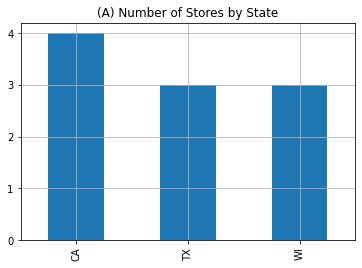

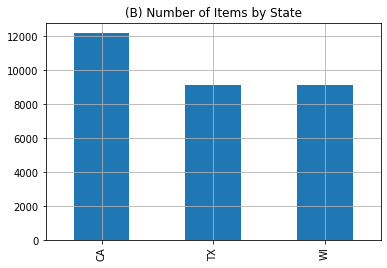

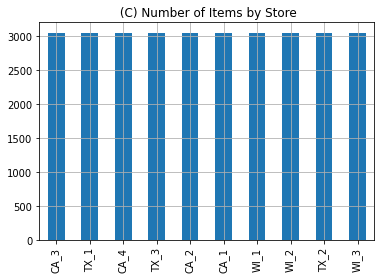

In [33]:
d = train_sales.groupby(['state_id','store_id']).count().reset_index()
d['state_id'].value_counts().plot(kind="bar", grid=True, title="(A) Number of Stores by State", yticks=[0,1,2,3,4])
plt.show()

d = train_sales.groupby(['state_id','id']).count().reset_index()
d['state_id'].value_counts().plot(kind="bar", grid=True, title="(B) Number of Items by State")
plt.show()

d = train_sales.groupby(['store_id','item_id']).count().reset_index()
d['store_id'].value_counts().plot(kind="bar", grid=True, title=" (C) Number of Items by Store")
plt.show()

This shows that we have data with 10 stores and 3049 items per store so as a result we have 30490 time series.

In [34]:
train_sales

id        item_id    dept_id   cat_id  \
0      HOBBIES_1_001_CA_1_validation  HOBBIES_1_001  HOBBIES_1  HOBBIES   
1      HOBBIES_1_002_CA_1_validation  HOBBIES_1_002  HOBBIES_1  HOBBIES   
2      HOBBIES_1_003_CA_1_validation  HOBBIES_1_003  HOBBIES_1  HOBBIES   
3      HOBBIES_1_004_CA_1_validation  HOBBIES_1_004  HOBBIES_1  HOBBIES   
4      HOBBIES_1_005_CA_1_validation  HOBBIES_1_005  HOBBIES_1  HOBBIES   
...                              ...            ...        ...      ...   
30485    FOODS_3_823_WI_3_validation    FOODS_3_823    FOODS_3    FOODS   
30486    FOODS_3_824_WI_3_validation    FOODS_3_824    FOODS_3    FOODS   
30487    FOODS_3_825_WI_3_validation    FOODS_3_825    FOODS_3    FOODS   
30488    FOODS_3_826_WI_3_validation    FOODS_3_826    FOODS_3    FOODS   
30489    FOODS_3_827_WI_3_validation    FOODS_3_827    FOODS_3    FOODS   

      store_id state_id  d_1  d_2  d_3  d_4  ...  d_1904  d_1905  d_1906  \
0         CA_1       CA    0    0    0    0  ...       1       3       0   
1         CA_1       CA    0    0    0    0  ...       0       0       0   
2         CA_1       CA    0    0    0    0  ...       2       1       2   
3         CA_1       CA    0    0    0    0  ...       1       0       5   
4         CA_1       CA    0    0    0    0  ...       2       1       1   
...        ...      ...  ...  ...  ...  ...  ...     ...     ...     ...   
30485     WI_3       WI    0    0    2    2  ...       2       0       0   
30486     WI_3       WI    0    0    0    0  ...       0       0       0   
30487     WI_3       WI    0    6    0    2  ...       2       1       0   
30488     WI_3       WI    0    0    0    0  ...       0       0       1   
30489     WI_3       WI    0    0    0    0  ...       0       0       0   

       d_1907  d_1908  d_1909  d_1910  d_1911  d_1912  d_1913  
0           1       1       1       3       0       1       1  
1           0       0       1       0       0       0       0  
2           1       1       1       0       1       1       1  
3           4       1       0       1       3       7       2  
4           0       1       1       2       2       2       4  
...       ...     ...     ...     ...     ...     ...     ...  
30485       0       0       0       1       0       0       1  
30486       0       0       0       0       0       1       0  
30487       2       0       1       0       0       1       0  
30488       0       0       1       0       3       1       3  
30489       0       0       0       0       0       0       0  

[30490 rows x 1919 columns]

In [35]:
d_cols = train_sales.columns.tolist()[6:]
d_cols


['d_1',
 'd_2',
 'd_3',
 'd_4',
 'd_5',
 'd_6',
 'd_7',
 'd_8',
 'd_9',
 'd_10',
 'd_11',
 'd_12',
 'd_13',
 'd_14',
 'd_15',
 'd_16',
 'd_17',
 'd_18',
 'd_19',
 'd_20',
 'd_21',
 'd_22',
 'd_23',
 'd_24',
 'd_25',
 'd_26',
 'd_27',
 'd_28',
 'd_29',
 'd_30',
 'd_31',
 'd_32',
 'd_33',
 'd_34',
 'd_35',
 'd_36',
 'd_37',
 'd_38',
 'd_39',
 'd_40',
 'd_41',
 'd_42',
 'd_43',
 'd_44',
 'd_45',
 'd_46',
 'd_47',
 'd_48',
 'd_49',
 'd_50',
 'd_51',
 'd_52',
 'd_53',
 'd_54',
 'd_55',
 'd_56',
 'd_57',
 'd_58',
 'd_59',
 'd_60',
 'd_61',
 'd_62',
 'd_63',
 'd_64',
 'd_65',
 'd_66',
 'd_67',
 'd_68',
 'd_69',
 'd_70',
 'd_71',
 'd_72',
 'd_73',
 'd_74',
 'd_75',
 'd_76',
 'd_77',
 'd_78',
 'd_79',
 'd_80',
 'd_81',
 'd_82',
 'd_83',
 'd_84',
 'd_85',
 'd_86',
 'd_87',
 'd_88',
 'd_89',
 'd_90',
 'd_91',
 'd_92',
 'd_93',
 'd_94',
 'd_95',
 'd_96',
 'd_97',
 'd_98',
 'd_99',
 'd_100',
 'd_101',
 'd_102',
 'd_103',
 'd_104',
 'd_105',
 'd_106',
 'd_107',
 'd_108',
 'd_109',
 'd_110',
 'd_111'

In [36]:
non_d_cols = list(reversed(train_sales.columns.tolist()[:6]))
non_d_cols

['state_id', 'store_id', 'cat_id', 'dept_id', 'item_id', 'id']

In [37]:
non_d_cols

['state_id', 'store_id', 'cat_id', 'dept_id', 'item_id', 'id']

In [38]:
train_sales.set_index(non_d_cols)

d_1  \
state_id store_id cat_id  dept_id   item_id       id                                   
CA       CA_1     HOBBIES HOBBIES_1 HOBBIES_1_001 HOBBIES_1_001_CA_1_validation    0   
                                    HOBBIES_1_002 HOBBIES_1_002_CA_1_validation    0   
                                    HOBBIES_1_003 HOBBIES_1_003_CA_1_validation    0   
                                    HOBBIES_1_004 HOBBIES_1_004_CA_1_validation    0   
                                    HOBBIES_1_005 HOBBIES_1_005_CA_1_validation    0   
...                                                                              ...   
WI       WI_3     FOODS   FOODS_3   FOODS_3_823   FOODS_3_823_WI_3_validation      0   
                                    FOODS_3_824   FOODS_3_824_WI_3_validation      0   
                                    FOODS_3_825   FOODS_3_825_WI_3_validation      0   
                                    FOODS_3_826   FOODS_3_826_WI_3_validation      0   
                                    FOODS_3_827   FOODS_3_827_WI_3_validation      0   

                                                                                 d_2  \
state_id store_id cat_id  dept_id   item_id       id                                   
CA       CA_1     HOBBIES HOBBIES_1 HOBBIES_1_001 HOBBIES_1_001_CA_1_validation    0   
                                    HOBBIES_1_002 HOBBIES_1_002_CA_1_validation    0   
                                    HOBBIES_1_003 HOBBIES_1_003_CA_1_validation    0   
                                    HOBBIES_1_004 HOBBIES_1_004_CA_1_validation    0   
                                    HOBBIES_1_005 HOBBIES_1_005_CA_1_validation    0   
...                                                                              ...   
WI       WI_3     FOODS   FOODS_3   FOODS_3_823   FOODS_3_823_WI_3_validation      0   
                                    FOODS_3_824   FOODS_3_824_WI_3_validation      0   
                                    FOODS_3_825   FOODS_3_825_WI_3_validation      6   
                                    FOODS_3_826   FOODS_3_826_WI_3_validation      0   
                                    FOODS_3_827   FOODS_3_827_WI_3_validation      0   

                                                                                 d_3  \
state_id store_id cat_id  dept_id   item_id       id                                   
CA       CA_1     HOBBIES HOBBIES_1 HOBBIES_1_001 HOBBIES_1_001_CA_1_validation    0   
                                    HOBBIES_1_002 HOBBIES_1_002_CA_1_validation    0   
                                    HOBBIES_1_003 HOBBIES_1_003_CA_1_validation    0   
                                    HOBBIES_1_004 HOBBIES_1_004_CA_1_validation    0   
                                    HOBBIES_1_005 HOBBIES_1_005_CA_1_validation    0   
...                                                                              ...   
WI       WI_3     FOODS   FOODS_3   FOODS_3_823   FOODS_3_823_WI_3_validation      2   
                                    FOODS_3_824   FOODS_3_824_WI_3_validation      0   
                                    FOODS_3_825   FOODS_3_825_WI_3_validation      0   
                                    FOODS_3_826   FOODS_3_826_WI_3_validation      0   
                                    FOODS_3_827   FOODS_3_827_WI_3_validation      0   

                                                                                 d_4  \
state_id store_id cat_id  dept_id   item_id       id                                   
CA       CA_1     HOBBIES HOBBIES_1 HOBBIES_1_001 HOBBIES_1_001_CA_1_validation    0   
                                    HOBBIES_1_002 HOBBIES_1_002_CA_1_validation    0   
                                    HOBBIES_1_003 HOBBIES_1_003_CA_1_validation    0   
                                    HOBBIES_1_004 HOBBIES_1_004_CA_1_validation    0   
                                    HOBBIES_1_005 HOBBIES_1_005_CA_1_validation    0   
...                           

In [39]:
train_sales.set_index(non_d_cols).stack().to_frame()

0
state_id store_id cat_id  dept_id   item_id       id                                     
CA       CA_1     HOBBIES HOBBIES_1 HOBBIES_1_001 HOBBIES_1_001_CA_1_validation d_1     0
                                                                                d_2     0
                                                                                d_3     0
                                                                                d_4     0
                                                                                d_5     0
...                                                                                    ..
WI       WI_3     FOODS   FOODS_3   FOODS_3_827   FOODS_3_827_WI_3_validation   d_1909  0
                                                                                d_1910  0
                                                                                d_1911  0
                                                                                d_1912  0
                                                                                d_1913  0

[58327370 rows x 1 columns]

In [40]:
# Transform Data Structure
data = train_sales.set_index(non_d_cols)
# the following will make one column for sales and one columns for "d" values (d_1 ... d_1913)
data = data.stack()
data = data.to_frame() 
data.columns = ["sales"]
data.reset_index(inplace=True)
data.columns = non_d_cols + ["d", "sales"]

In [41]:
data

state_id store_id   cat_id    dept_id        item_id  \
0              CA     CA_1  HOBBIES  HOBBIES_1  HOBBIES_1_001   
1              CA     CA_1  HOBBIES  HOBBIES_1  HOBBIES_1_001   
2              CA     CA_1  HOBBIES  HOBBIES_1  HOBBIES_1_001   
3              CA     CA_1  HOBBIES  HOBBIES_1  HOBBIES_1_001   
4              CA     CA_1  HOBBIES  HOBBIES_1  HOBBIES_1_001   
...           ...      ...      ...        ...            ...   
58327365       WI     WI_3    FOODS    FOODS_3    FOODS_3_827   
58327366       WI     WI_3    FOODS    FOODS_3    FOODS_3_827   
58327367       WI     WI_3    FOODS    FOODS_3    FOODS_3_827   
58327368       WI     WI_3    FOODS    FOODS_3    FOODS_3_827   
58327369       WI     WI_3    FOODS    FOODS_3    FOODS_3_827   

                                     id       d  sales  
0         HOBBIES_1_001_CA_1_validation     d_1      0  
1         HOBBIES_1_001_CA_1_validation     d_2      0  
2         HOBBIES_1_001_CA_1_validation     d_3      0  
3         HOBBIES_1_001_CA_1_validation     d_4      0  
4         HOBBIES_1_001_CA_1_validation     d_5      0  
...                                 ...     ...    ...  
58327365    FOODS_3_827_WI_3_validation  d_1909      0  
58327366    FOODS_3_827_WI_3_validation  d_1910      0  
58327367    FOODS_3_827_WI_3_validation  d_1911      0  
58327368    FOODS_3_827_WI_3_validation  d_1912      0  
58327369    FOODS_3_827_WI_3_validation  d_1913      0  

[58327370 rows x 8 columns]

Initially we have data with 10 stores and 3049 items per store so as a result we have 30490 time series !
Each time series contains sales data of 1913 days. Final output data will have then 8 columns and 30490*1913 = 58327370 rows !

In [42]:
data.groupby(['state_id', 'd']).sum()

sales
state_id d            
CA       d_1     14195
         d_10    11822
         d_100   11231
         d_1000  13066
         d_1001  14957
...                ...
WI       d_995   10940
         d_996   10494
         d_997    7755
         d_998    7271
         d_999    7948

[5739 rows x 1 columns]

In [45]:
data.groupby('cat_id')['sales'].transform(lambda x: x.rolling(7, 1).mean())

0           0.0
1           0.0
2           0.0
3           0.0
4           0.0
           ... 
58327365    0.0
58327366    0.0
58327367    0.0
58327368    0.0
58327369    0.0
Name: sales, Length: 58327370, dtype: float64

In [ ]:
df.groupby('group')['values'].transform(lambda x: x.rolling(3, 1).mean())

In [51]:
# preparing state-level data
state_data = data.groupby(['state_id', 'd']).sum()
state_data = state_data.reset_index()
state_data = merge_with_calendar(state_data, calendar)

In [52]:
state_data

d        date  wm_yr_wk   weekday  wday  month  year event_name_1  \
0        d_1  2011-01-29     11101  Saturday     1      1  2011         None   
1        d_1  2011-01-29     11101  Saturday     1      1  2011         None   
2        d_1  2011-01-29     11101  Saturday     1      1  2011         None   
3        d_2  2011-01-30     11101    Sunday     2      1  2011         None   
4        d_2  2011-01-30     11101    Sunday     2      1  2011         None   
...      ...         ...       ...       ...   ...    ...   ...          ...   
5734  d_1912  2016-04-23     11613  Saturday     1      4  2016         None   
5735  d_1912  2016-04-23     11613  Saturday     1      4  2016         None   
5736  d_1913  2016-04-24     11613    Sunday     2      4  2016         None   
5737  d_1913  2016-04-24     11613    Sunday     2      4  2016         None   
5738  d_1913  2016-04-24     11613    Sunday     2      4  2016         None   

     event_type_1 event_type_2 event_name_2 state_id  sales  
0            None         None         None       CA  14195  
1            None         None         None       TX   9438  
2            None         None         None       WI   8998  
3            None         None         None       CA  13805  
4            None         None         None       TX   9630  
...           ...          ...          ...      ...    ...  
5734         None         None         None       TX  12266  
5735         None         None         None       WI  14862  
5736         None         None         None       CA  23187  
5737         None         None         None       TX  12282  
5738         None         None         None       WI  14326  

[5739 rows x 13 columns]

# Category level analysis

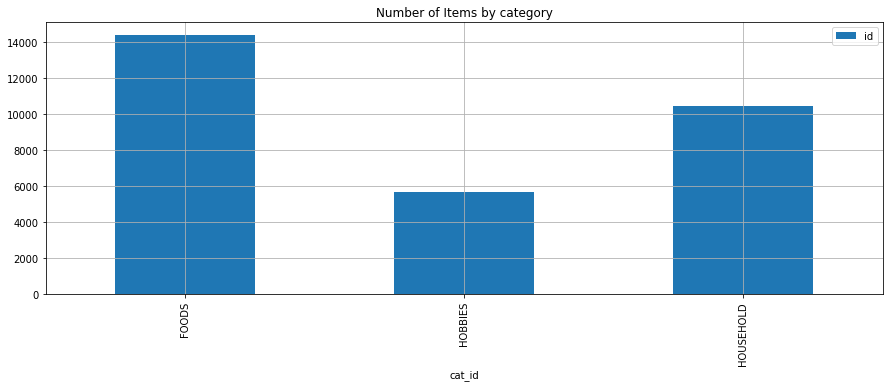

In [65]:
train_sales.groupby('cat_id').count()['id'].reset_index().plot(x = 'cat_id', kind = 'bar', figsize = (15, 5), grid = True, title = 'Number of Items by category')
plt.show()

FOODS is the category having the highest number of sales, HOBBIES having the lowest one

In [66]:
data.groupby(["cat_id","d"]).sum()['sales'].reset_index()

cat_id       d  sales
0         FOODS     d_1  23178
1         FOODS    d_10  18901
2         FOODS   d_100  16383
3         FOODS  d_1000  19276
4         FOODS  d_1001  22628
...         ...     ...    ...
5734  HOUSEHOLD   d_995   9863
5735  HOUSEHOLD   d_996  10004
5736  HOUSEHOLD   d_997   7317
5737  HOUSEHOLD   d_998   6592
5738  HOUSEHOLD   d_999   6588

[5739 rows x 3 columns]

In [67]:
# Preparing category-level data
cat_data = data.groupby(["cat_id","d"]).sum()["sales"]
cat_data = cat_data.reset_index()
cat_data = merge_with_calendar(cat_data, calendar)

In [68]:
cat_data

d        date  wm_yr_wk   weekday  wday  month  year event_name_1  \
0        d_1  2011-01-29     11101  Saturday     1      1  2011         None   
1        d_1  2011-01-29     11101  Saturday     1      1  2011         None   
2        d_1  2011-01-29     11101  Saturday     1      1  2011         None   
3        d_2  2011-01-30     11101    Sunday     2      1  2011         None   
4        d_2  2011-01-30     11101    Sunday     2      1  2011         None   
...      ...         ...       ...       ...   ...    ...   ...          ...   
5734  d_1912  2016-04-23     11613  Saturday     1      4  2016         None   
5735  d_1912  2016-04-23     11613  Saturday     1      4  2016         None   
5736  d_1913  2016-04-24     11613    Sunday     2      4  2016         None   
5737  d_1913  2016-04-24     11613    Sunday     2      4  2016         None   
5738  d_1913  2016-04-24     11613    Sunday     2      4  2016         None   

     event_type_1 event_type_2 event_name_2     cat_id  sales  
0            None         None         None      FOODS  23178  
1            None         None         None    HOBBIES   3764  
2            None         None         None  HOUSEHOLD   5689  
3            None         None         None      FOODS  22758  
4            None         None         None    HOBBIES   3357  
...           ...          ...          ...        ...    ...  
5734         None         None         None    HOBBIES   4787  
5735         None         None         None  HOUSEHOLD  12248  
5736         None         None         None      FOODS  32654  
5737         None         None         None    HOBBIES   4683  
5738         None         None         None  HOUSEHOLD  12458  

[5739 rows x 13 columns]

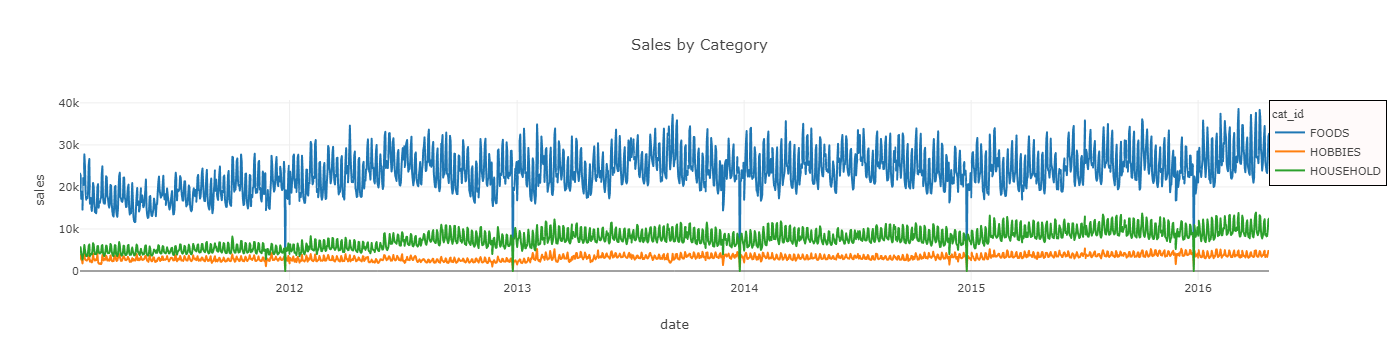

In [69]:
plot_daily_data(cat_data,'cat')

In [71]:
#plot_yearly_data(cat_data,'cat')

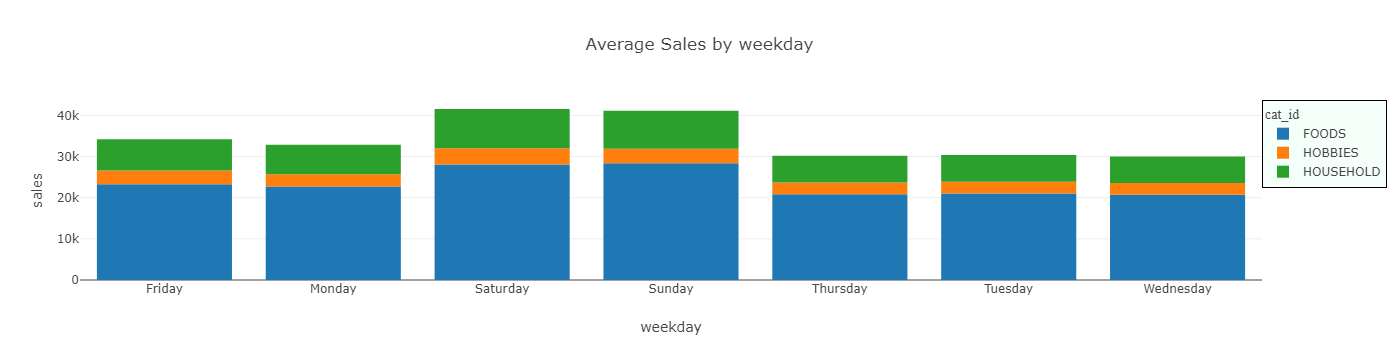

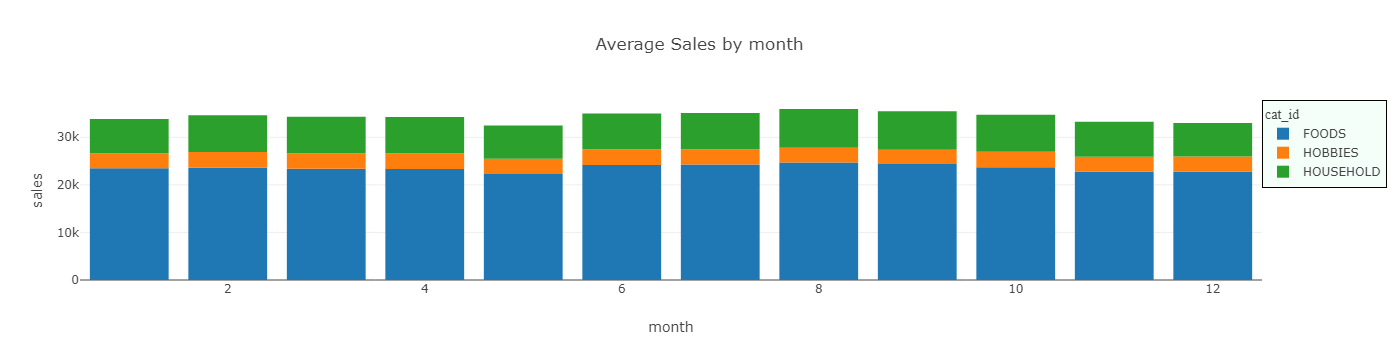

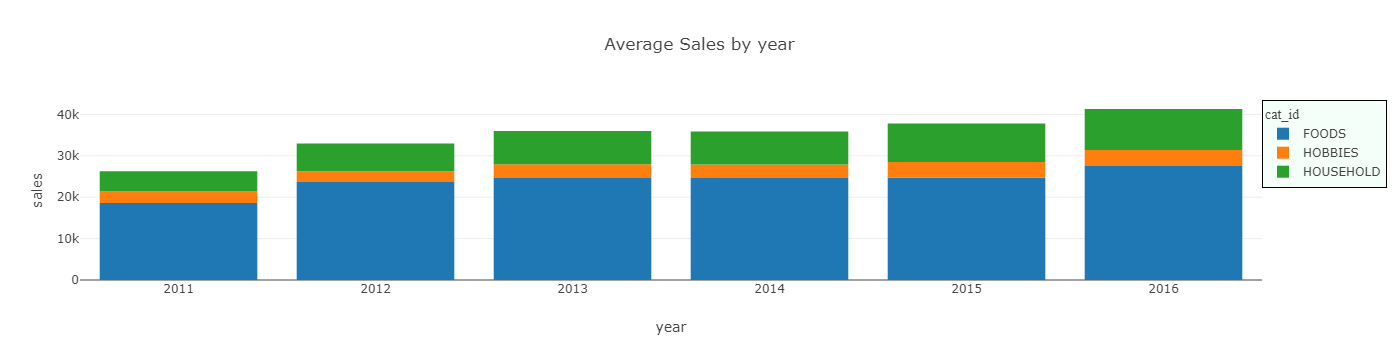

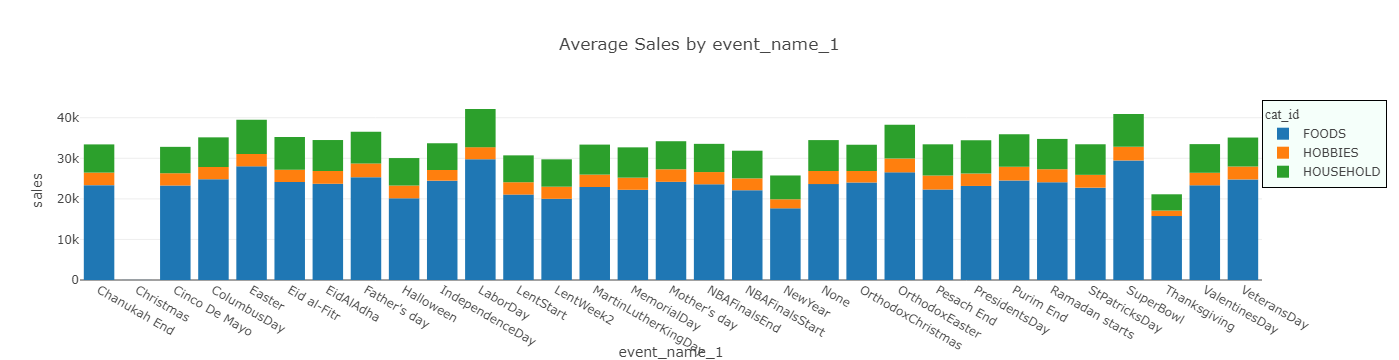

In [90]:
plot_average_sales(cat_data,'cat')

#  Department Level Analysis

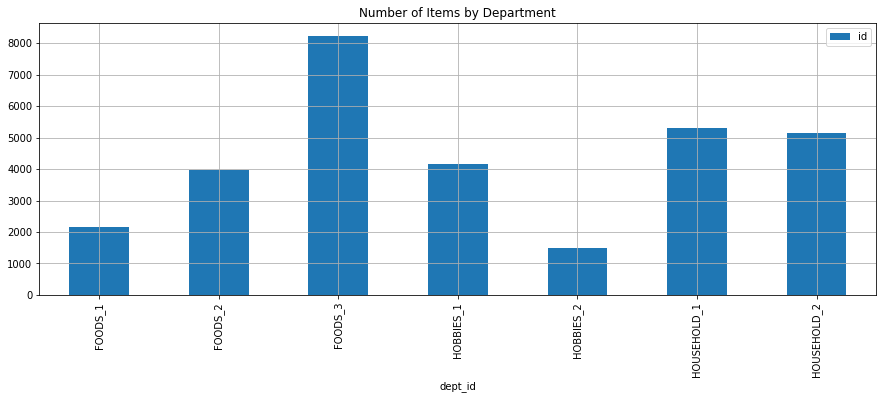

In [73]:
train_sales.groupby('dept_id').count()['id'].reset_index().plot(x='dept_id', kind='bar', figsize=(15,5), grid=True, title='Number of Items by Department')
plt.show()

In [74]:
# Preparing department-level data
dept_data = data.groupby(["dept_id","d"]).sum()["sales"]
dept_data = dept_data.reset_index()
dept_data = merge_with_calendar(dept_data, calendar)

In [75]:
dept_data

d        date  wm_yr_wk   weekday  wday  month  year event_name_1  \
0         d_1  2011-01-29     11101  Saturday     1      1  2011         None   
1         d_1  2011-01-29     11101  Saturday     1      1  2011         None   
2         d_1  2011-01-29     11101  Saturday     1      1  2011         None   
3         d_1  2011-01-29     11101  Saturday     1      1  2011         None   
4         d_1  2011-01-29     11101  Saturday     1      1  2011         None   
...       ...         ...       ...       ...   ...    ...   ...          ...   
13386  d_1913  2016-04-24     11613    Sunday     2      4  2016         None   
13387  d_1913  2016-04-24     11613    Sunday     2      4  2016         None   
13388  d_1913  2016-04-24     11613    Sunday     2      4  2016         None   
13389  d_1913  2016-04-24     11613    Sunday     2      4  2016         None   
13390  d_1913  2016-04-24     11613    Sunday     2      4  2016         None   

      event_type_1 event_type_2 event_name_2      dept_id  sales  
0             None         None         None      FOODS_1   2343  
1             None         None         None      FOODS_2   4094  
2             None         None         None      FOODS_3  16741  
3             None         None         None    HOBBIES_1   3610  
4             None         None         None    HOBBIES_2    154  
...            ...          ...          ...          ...    ...  
13386         None         None         None      FOODS_3  22996  
13387         None         None         None    HOBBIES_1   4226  
13388         None         None         None    HOBBIES_2    457  
13389         None         None         None  HOUSEHOLD_1   9795  
13390         None         None         None  HOUSEHOLD_2   2663  

[13391 rows x 13 columns]

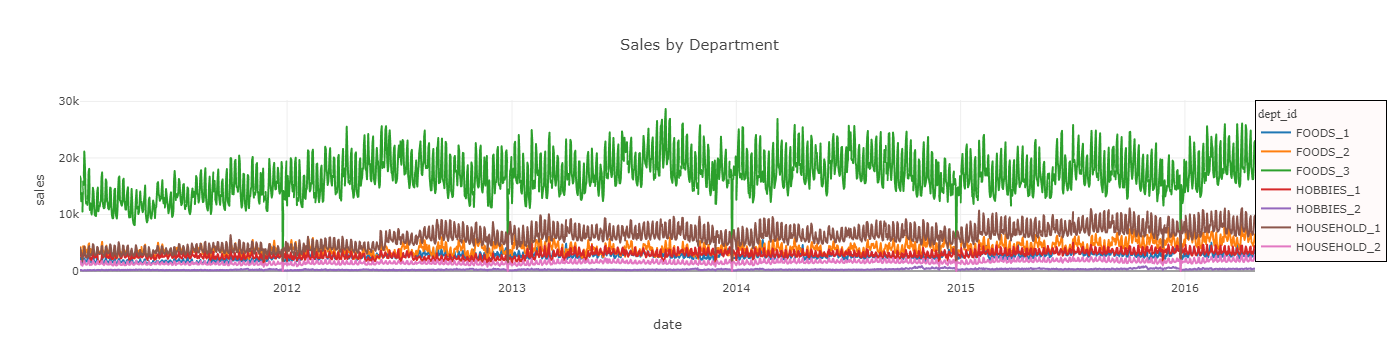

In [76]:
plot_daily_data(dept_data,'dept')

In [77]:
#plot_yearly_data(dept_data,'dept')

# Store Level Analysis

In [78]:
store_data = data.groupby(["store_id","d"]).sum()["sales"]
store_data = store_data.reset_index()
store_data = merge_with_calendar(store_data, calendar)

In [79]:
store_data

d        date  wm_yr_wk   weekday  wday  month  year event_name_1  \
0         d_1  2011-01-29     11101  Saturday     1      1  2011         None   
1         d_1  2011-01-29     11101  Saturday     1      1  2011         None   
2         d_1  2011-01-29     11101  Saturday     1      1  2011         None   
3         d_1  2011-01-29     11101  Saturday     1      1  2011         None   
4         d_1  2011-01-29     11101  Saturday     1      1  2011         None   
...       ...         ...       ...       ...   ...    ...   ...          ...   
19125  d_1913  2016-04-24     11613    Sunday     2      4  2016         None   
19126  d_1913  2016-04-24     11613    Sunday     2      4  2016         None   
19127  d_1913  2016-04-24     11613    Sunday     2      4  2016         None   
19128  d_1913  2016-04-24     11613    Sunday     2      4  2016         None   
19129  d_1913  2016-04-24     11613    Sunday     2      4  2016         None   

      event_type_1 event_type_2 event_name_2 store_id  sales  
0             None         None         None     CA_1   4337  
1             None         None         None     CA_2   3494  
2             None         None         None     CA_3   4739  
3             None         None         None     CA_4   1625  
4             None         None         None     TX_1   2556  
...            ...          ...          ...      ...    ...  
19125         None         None         None     TX_2   4292  
19126         None         None         None     TX_3   3957  
19127         None         None         None     WI_1   4874  
19128         None         None         None     WI_2   5127  
19129         None         None         None     WI_3   4325  

[19130 rows x 13 columns]

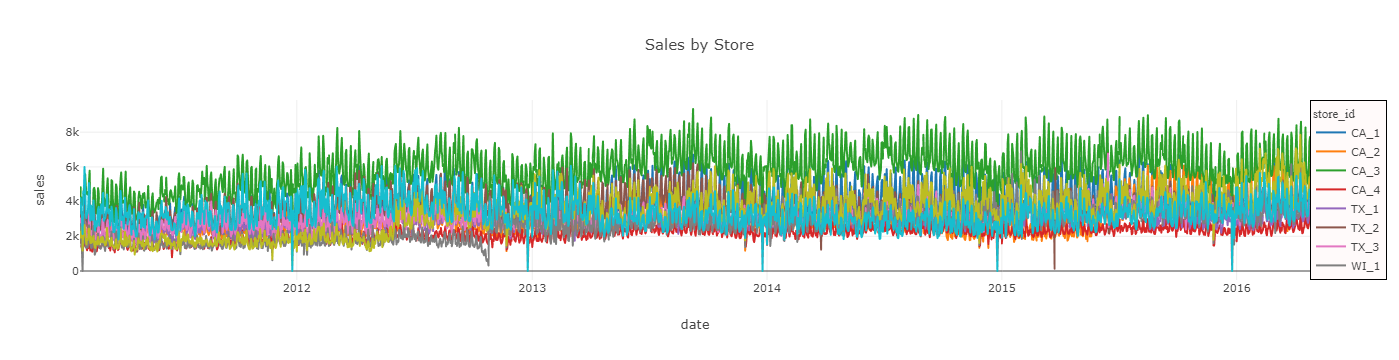

In [80]:
plot_daily_data(store_data,'store')

In [81]:
#fig = px.histogram(store_data,
 #                  x='sales',
  #                 color='store_id',
   #                marginal='box',
    #               title='Sales Distribution By Store')
#fig.show()

In [82]:
#plot_yearly_data(store_data,'store')

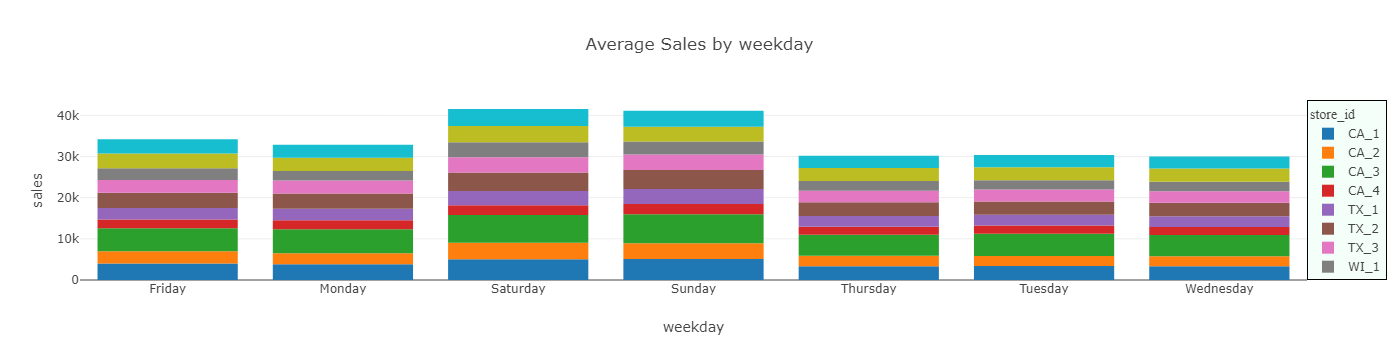

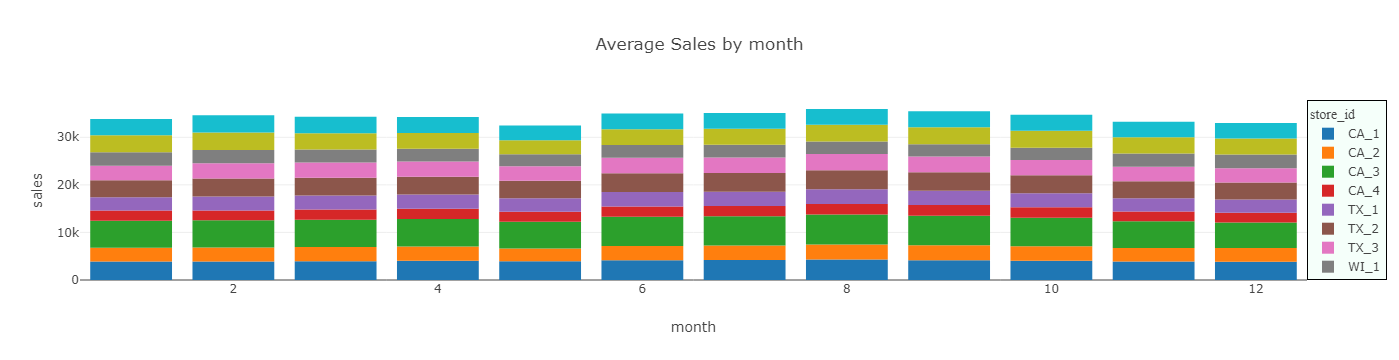

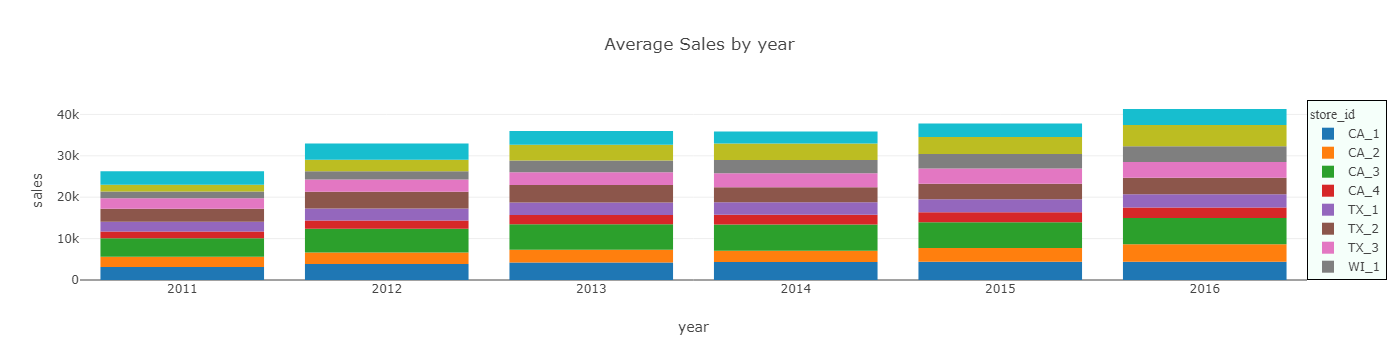

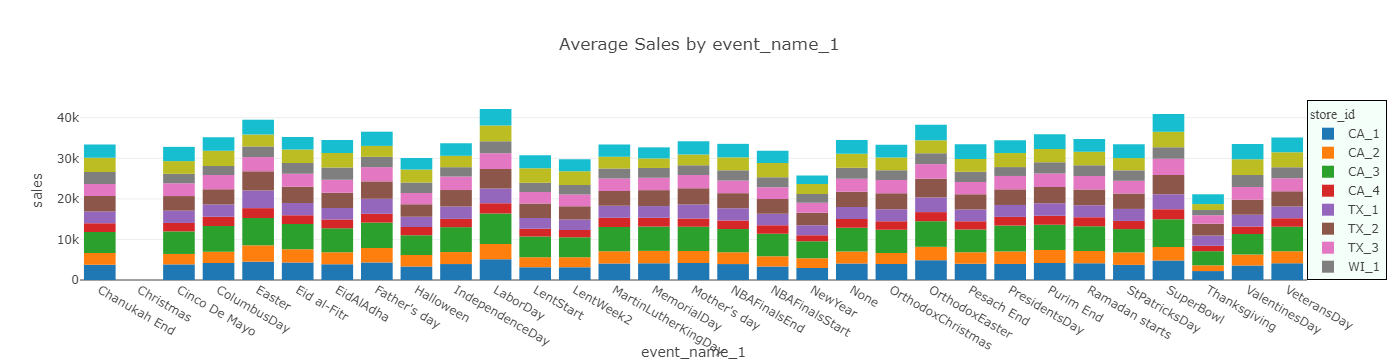

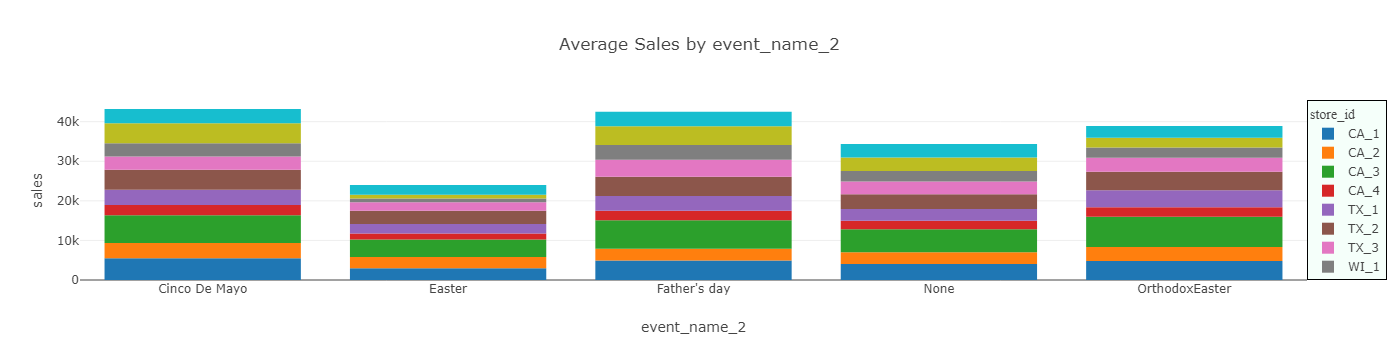

In [83]:
plot_average_sales(store_data,'store')

# Category level analysis

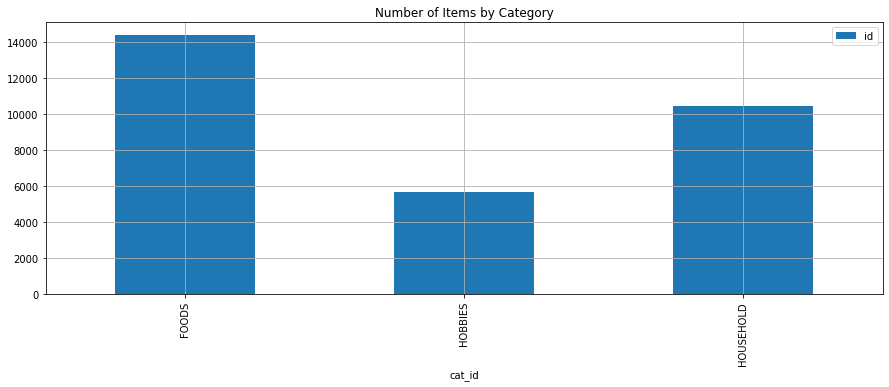

In [89]:
train_sales.groupby('cat_id').count()['id'].reset_index().plot(x='cat_id', 
                                                              kind='bar', 
                                                              figsize=(15,5),
                                                              grid=True,
                                                              title='Number of Items by Category')
plt.show()

In [90]:
# Preparing category-level data
cat_data = data.groupby(["cat_id","d"]).sum()["sales"]
cat_data = cat_data.reset_index()
cat_data = merge_with_calendar(cat_data, calendar)

In [91]:
cat_data.head()

d        date  wm_yr_wk   weekday  wday  month  year event_name_1  \
0  d_1  2011-01-29     11101  Saturday     1      1  2011         None   
1  d_1  2011-01-29     11101  Saturday     1      1  2011         None   
2  d_1  2011-01-29     11101  Saturday     1      1  2011         None   
3  d_2  2011-01-30     11101    Sunday     2      1  2011         None   
4  d_2  2011-01-30     11101    Sunday     2      1  2011         None   

  event_type_1 event_type_2 event_name_2     cat_id  sales  
0         None         None         None      FOODS  23178  
1         None         None         None    HOBBIES   3764  
2         None         None         None  HOUSEHOLD   5689  
3         None         None         None      FOODS  22758  
4         None         None         None    HOBBIES   3357

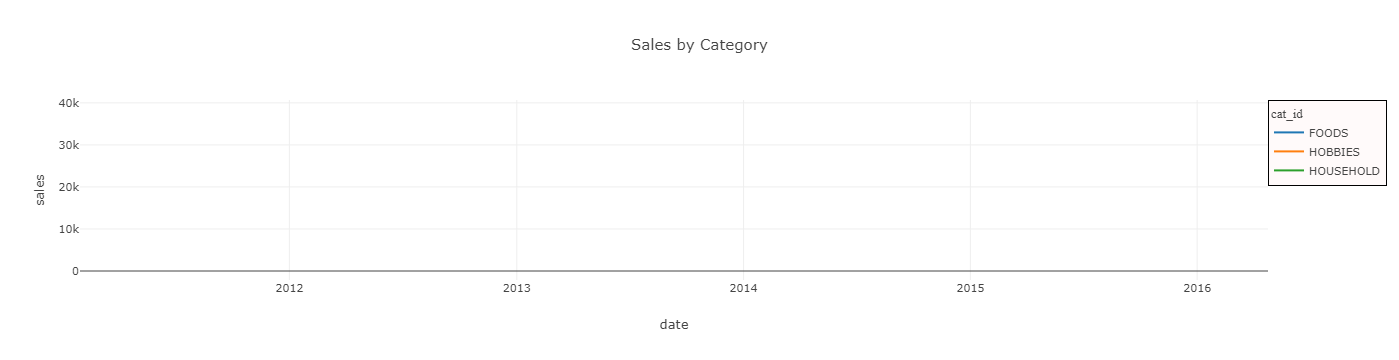

In [92]:
plot_daily_data(cat_data,'cat')

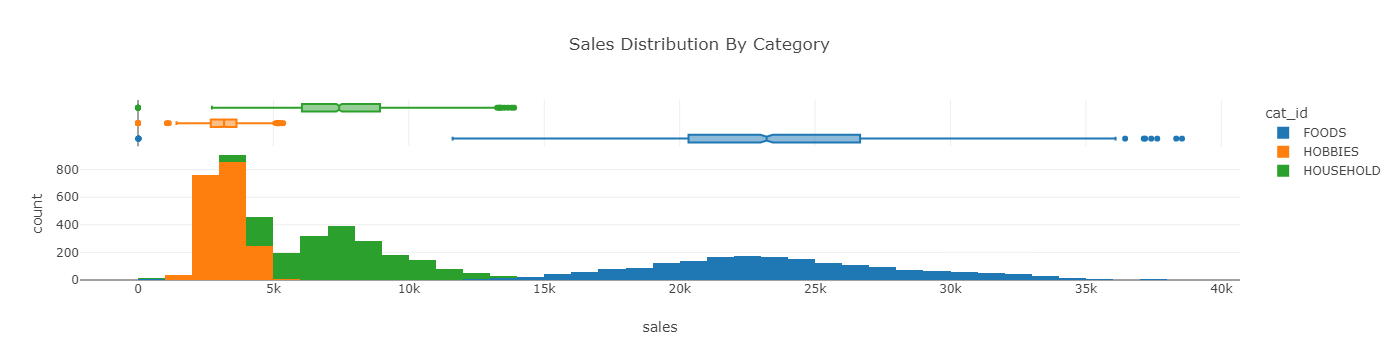

In [93]:
fig = px.histogram(cat_data,
                   x='sales',
                   color='cat_id',
                   marginal='box',
                   title='Sales Distribution By Category')
fig.show()

In [ ]:
#plot_yearly_data(cat_data,'cat')

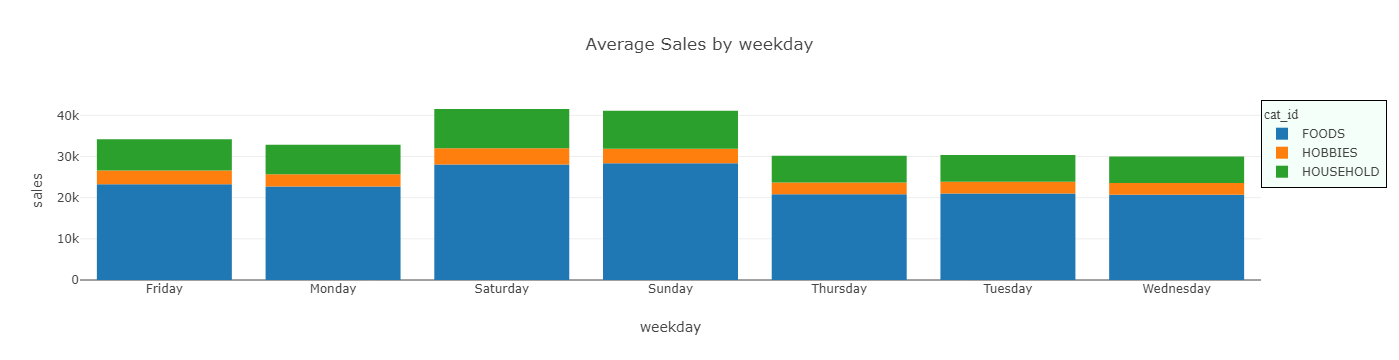

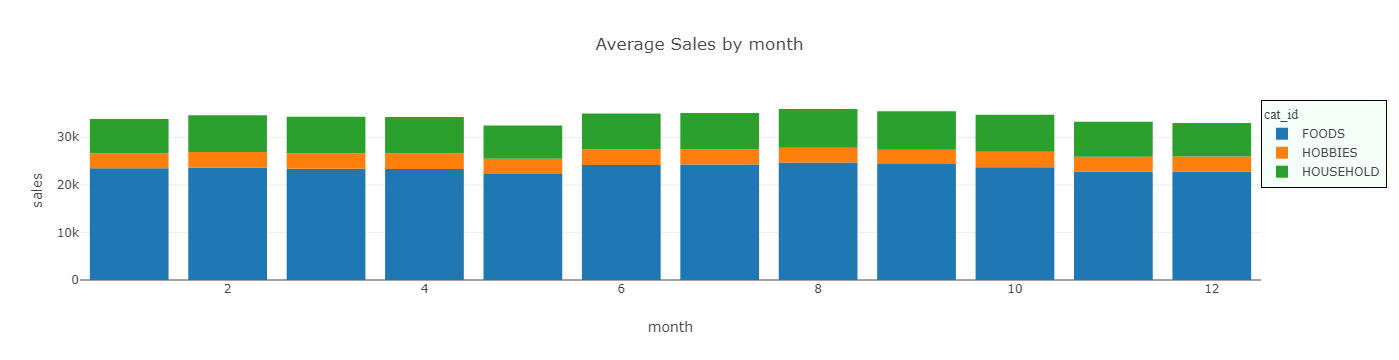

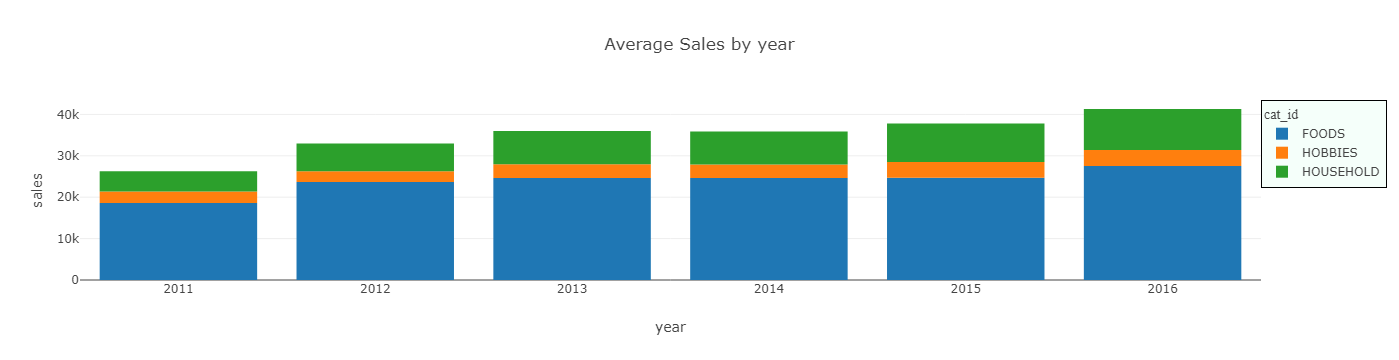

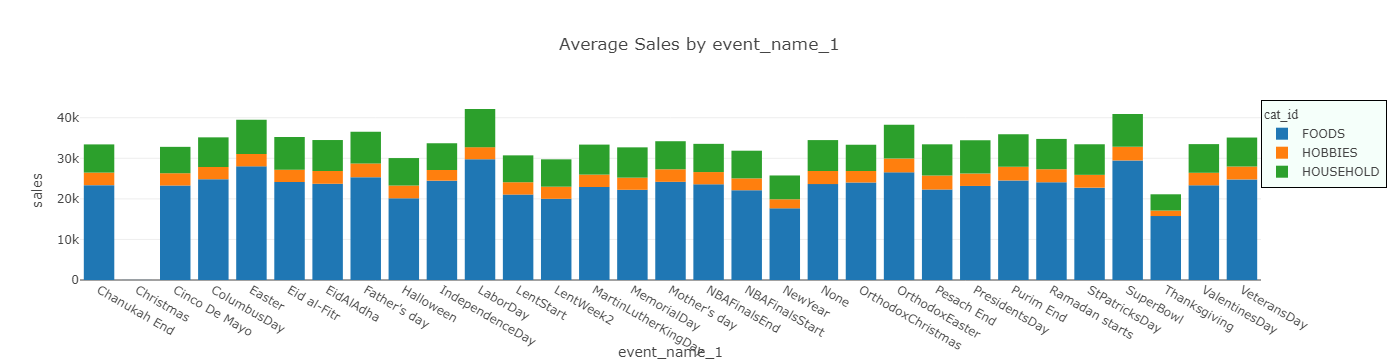

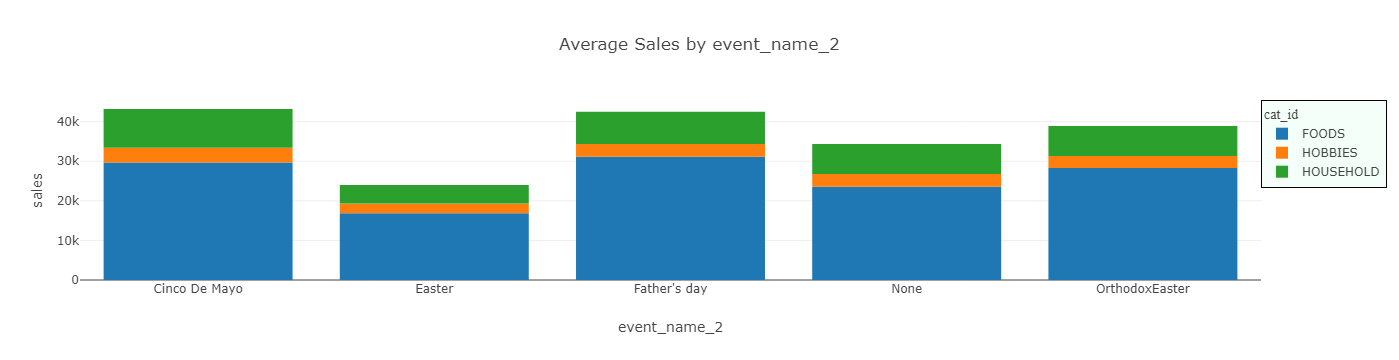

In [ ]:
plot_average_sales(cat_data,'cat')

# Department Level Analysis

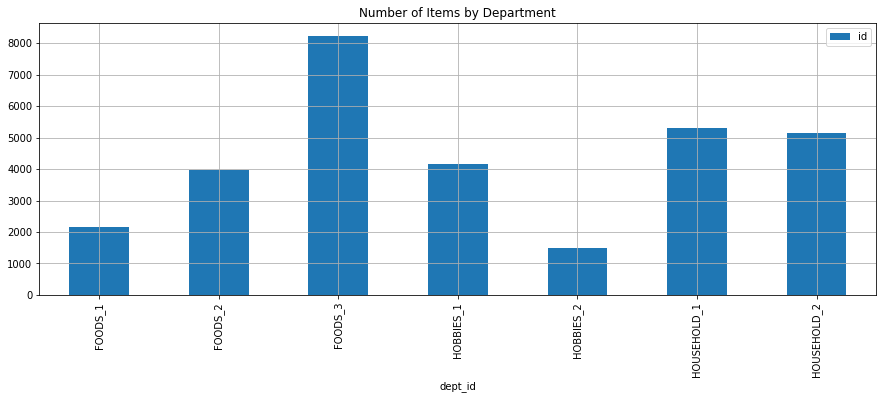

In [96]:
train_sales.groupby('dept_id').count()['id'].reset_index().plot(x='dept_id', 
                                                              kind='bar', 
                                                              figsize=(15,5),
                                                              grid=True,
                                                              title='Number of Items by Department')
plt.show()

In [97]:
# Preparing department-level data
dept_data = data.groupby(["dept_id","d"]).sum()["sales"]
dept_data = dept_data.reset_index()
dept_data = merge_with_calendar(dept_data, calendar)

In [98]:
dept_data.head()

d        date  wm_yr_wk   weekday  wday  month  year event_name_1  \
0  d_1  2011-01-29     11101  Saturday     1      1  2011         None   
1  d_1  2011-01-29     11101  Saturday     1      1  2011         None   
2  d_1  2011-01-29     11101  Saturday     1      1  2011         None   
3  d_1  2011-01-29     11101  Saturday     1      1  2011         None   
4  d_1  2011-01-29     11101  Saturday     1      1  2011         None   

  event_type_1 event_type_2 event_name_2    dept_id  sales  
0         None         None         None    FOODS_1   2343  
1         None         None         None    FOODS_2   4094  
2         None         None         None    FOODS_3  16741  
3         None         None         None  HOBBIES_1   3610  
4         None         None         None  HOBBIES_2    154

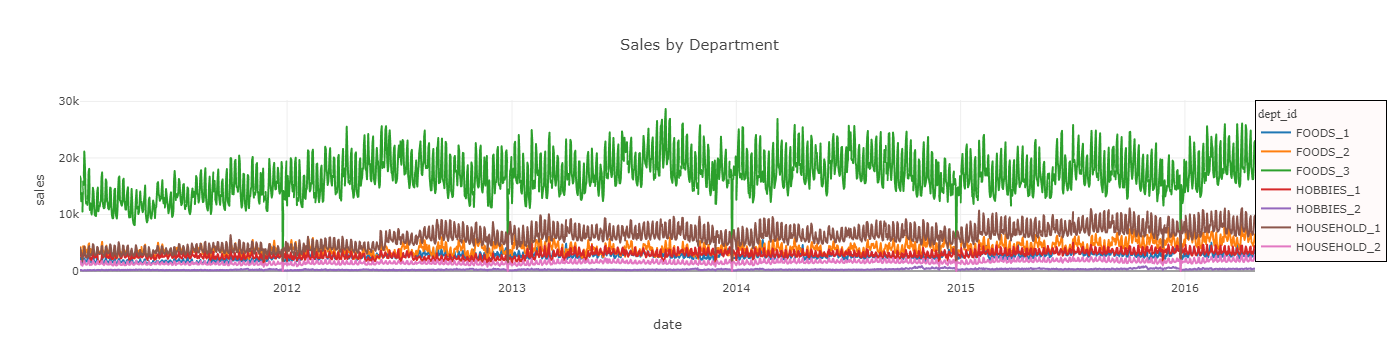

In [99]:
plot_daily_data(dept_data,'dept')

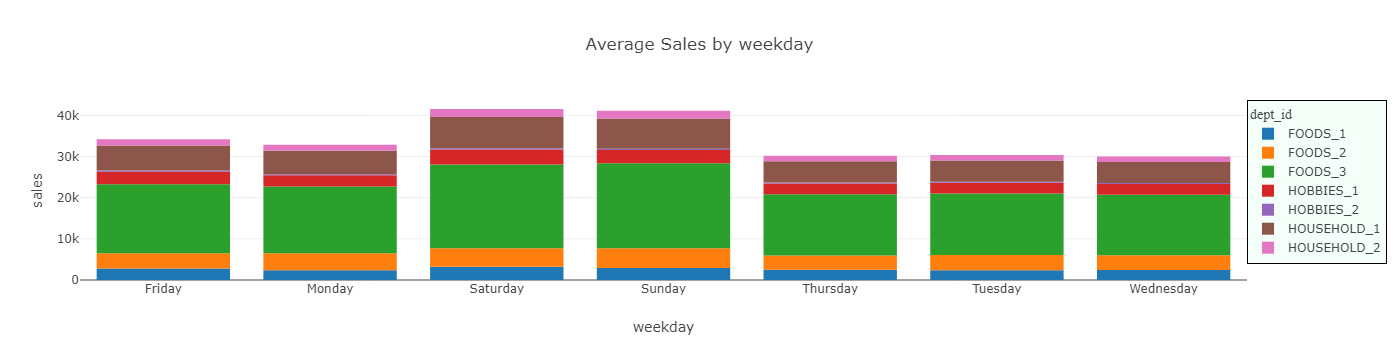

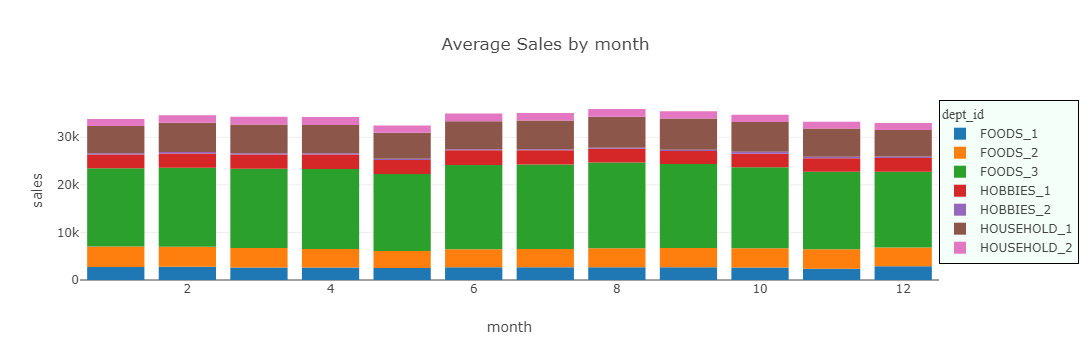

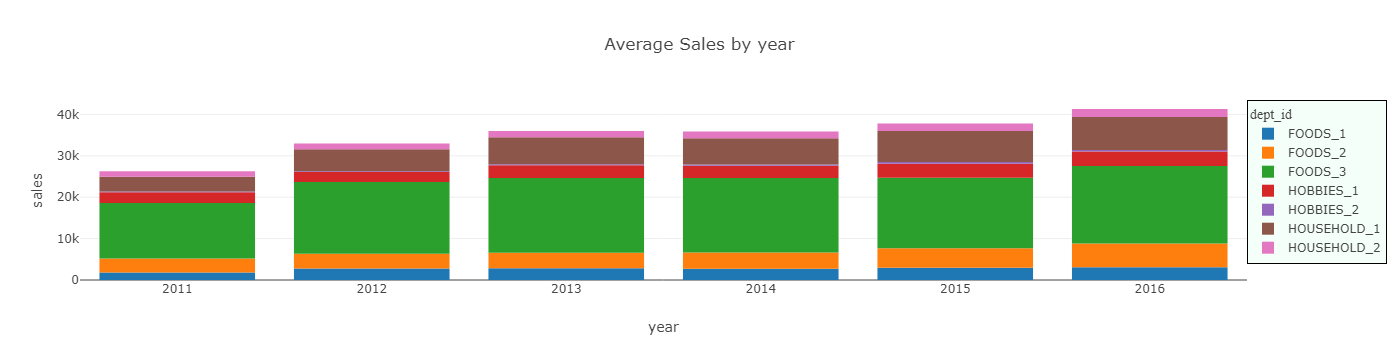

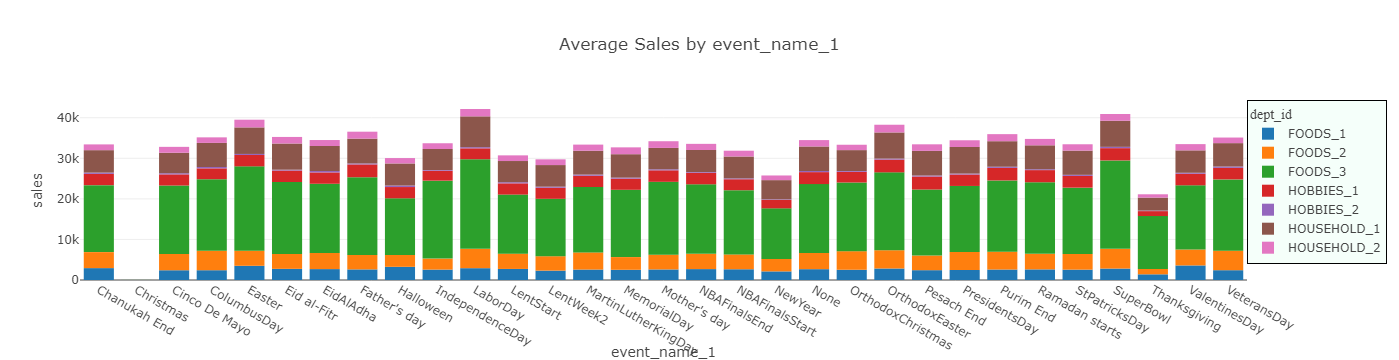

In [100]:
plot_average_sales(dept_data,'dept')

In [4]:
train_sales = pd.read_csv(path+'sales_train_validation.csv')
calendar = pd.read_csv(path+'calendar.csv')
sell_prices = pd.read_csv(path+'sell_prices.csv')

In [91]:
train_sales

id        item_id    dept_id   cat_id  \
0      HOBBIES_1_001_CA_1_validation  HOBBIES_1_001  HOBBIES_1  HOBBIES   
1      HOBBIES_1_002_CA_1_validation  HOBBIES_1_002  HOBBIES_1  HOBBIES   
2      HOBBIES_1_003_CA_1_validation  HOBBIES_1_003  HOBBIES_1  HOBBIES   
3      HOBBIES_1_004_CA_1_validation  HOBBIES_1_004  HOBBIES_1  HOBBIES   
4      HOBBIES_1_005_CA_1_validation  HOBBIES_1_005  HOBBIES_1  HOBBIES   
...                              ...            ...        ...      ...   
30485    FOODS_3_823_WI_3_validation    FOODS_3_823    FOODS_3    FOODS   
30486    FOODS_3_824_WI_3_validation    FOODS_3_824    FOODS_3    FOODS   
30487    FOODS_3_825_WI_3_validation    FOODS_3_825    FOODS_3    FOODS   
30488    FOODS_3_826_WI_3_validation    FOODS_3_826    FOODS_3    FOODS   
30489    FOODS_3_827_WI_3_validation    FOODS_3_827    FOODS_3    FOODS   

      store_id state_id  d_1  d_2  d_3  d_4  ...  d_1904  d_1905  d_1906  \
0         CA_1       CA    0    0    0    0  ...       1       3       0   
1         CA_1       CA    0    0    0    0  ...       0       0       0   
2         CA_1       CA    0    0    0    0  ...       2       1       2   
3         CA_1       CA    0    0    0    0  ...       1       0       5   
4         CA_1       CA    0    0    0    0  ...       2       1       1   
...        ...      ...  ...  ...  ...  ...  ...     ...     ...     ...   
30485     WI_3       WI    0    0    2    2  ...       2       0       0   
30486     WI_3       WI    0    0    0    0  ...       0       0       0   
30487     WI_3       WI    0    6    0    2  ...       2       1       0   
30488     WI_3       WI    0    0    0    0  ...       0       0       1   
30489     WI_3       WI    0    0    0    0  ...       0       0       0   

       d_1907  d_1908  d_1909  d_1910  d_1911  d_1912  d_1913  
0           1       1       1       3       0       1       1  
1           0       0       1       0       0       0       0  
2           1       1       1       0       1       1       1  
3           4       1       0       1       3       7       2  
4           0       1       1       2       2       2       4  
...       ...     ...     ...     ...     ...     ...     ...  
30485       0       0       0       1       0       0       1  
30486       0       0       0       0       0       1       0  
30487       2       0       1       0       0       1       0  
30488       0       0       1       0       3       1       3  
30489       0       0       0       0       0       0       0  

[30490 rows x 1919 columns]

In [92]:
calendar

date  wm_yr_wk    weekday  wday  month  year       d  \
0     2011-01-29     11101   Saturday     1      1  2011     d_1   
1     2011-01-30     11101     Sunday     2      1  2011     d_2   
2     2011-01-31     11101     Monday     3      1  2011     d_3   
3     2011-02-01     11101    Tuesday     4      2  2011     d_4   
4     2011-02-02     11101  Wednesday     5      2  2011     d_5   
...          ...       ...        ...   ...    ...   ...     ...   
1964  2016-06-15     11620  Wednesday     5      6  2016  d_1965   
1965  2016-06-16     11620   Thursday     6      6  2016  d_1966   
1966  2016-06-17     11620     Friday     7      6  2016  d_1967   
1967  2016-06-18     11621   Saturday     1      6  2016  d_1968   
1968  2016-06-19     11621     Sunday     2      6  2016  d_1969   

      event_name_1 event_type_1  event_name_2 event_type_2  snap_CA  snap_TX  \
0              NaN          NaN           NaN          NaN        0        0   
1              NaN          NaN           NaN          NaN        0        0   
2              NaN          NaN           NaN          NaN        0        0   
3              NaN          NaN           NaN          NaN        1        1   
4              NaN          NaN           NaN          NaN        1        0   
...            ...          ...           ...          ...      ...      ...   
1964           NaN          NaN           NaN          NaN        0        1   
1965           NaN          NaN           NaN          NaN        0        0   
1966           NaN          NaN           NaN          NaN        0        0   
1967           NaN          NaN           NaN          NaN        0        0   
1968  NBAFinalsEnd     Sporting  Father's day     Cultural        0        0   

      snap_WI  
0           0  
1           0  
2           0  
3           0  
4           1  
...       ...  
1964        1  
1965        0  
1966        0  
1967        0  
1968        0  

[1969 rows x 14 columns]

In [93]:
sell_prices

store_id        item_id  wm_yr_wk  sell_price
0           CA_1  HOBBIES_1_001     11325        9.58
1           CA_1  HOBBIES_1_001     11326        9.58
2           CA_1  HOBBIES_1_001     11327        8.26
3           CA_1  HOBBIES_1_001     11328        8.26
4           CA_1  HOBBIES_1_001     11329        8.26
...          ...            ...       ...         ...
6841116     WI_3    FOODS_3_827     11617        1.00
6841117     WI_3    FOODS_3_827     11618        1.00
6841118     WI_3    FOODS_3_827     11619        1.00
6841119     WI_3    FOODS_3_827     11620        1.00
6841120     WI_3    FOODS_3_827     11621        1.00

[6841121 rows x 4 columns]

In [5]:
# merging calendar and price data on week, month and year
# The price is provided per week (average across seven days)

sell_prices_calendar = pd.merge(sell_prices, calendar, on = 'wm_yr_wk')
#sell_prices_calendar.head()

In [6]:
sell_prices_calendar.head()

store_id        item_id  wm_yr_wk  sell_price        date    weekday  wday  \
0     CA_1  HOBBIES_1_001     11325        9.58  2013-07-13   Saturday     1   
1     CA_1  HOBBIES_1_001     11325        9.58  2013-07-14     Sunday     2   
2     CA_1  HOBBIES_1_001     11325        9.58  2013-07-15     Monday     3   
3     CA_1  HOBBIES_1_001     11325        9.58  2013-07-16    Tuesday     4   
4     CA_1  HOBBIES_1_001     11325        9.58  2013-07-17  Wednesday     5   

   month  year      d event_name_1 event_type_1 event_name_2 event_type_2  \
0      7  2013  d_897          NaN          NaN          NaN          NaN   
1      7  2013  d_898          NaN          NaN          NaN          NaN   
2      7  2013  d_899          NaN          NaN          NaN          NaN   
3      7  2013  d_900          NaN          NaN          NaN          NaN   
4      7  2013  d_901          NaN          NaN          NaN          NaN   

   snap_CA  snap_TX  snap_WI  
0        0        1        0  
1        0        0        1  
2        0        1        1  
3        0        0        0  
4        0        0        0

In [7]:
len(sell_prices_calendar)

47735397

In [11]:
reduced_sell_prices_calendar = sell_prices_calendar.drop(['wm_yr_wk','weekday','wday','month','year',], axis=1)

In [12]:
reduced_sell_prices_calendar.head()

store_id        item_id  sell_price        date      d event_name_1  \
0     CA_1  HOBBIES_1_001        9.58  2013-07-13  d_897          NaN   
1     CA_1  HOBBIES_1_001        9.58  2013-07-14  d_898          NaN   
2     CA_1  HOBBIES_1_001        9.58  2013-07-15  d_899          NaN   
3     CA_1  HOBBIES_1_001        9.58  2013-07-16  d_900          NaN   
4     CA_1  HOBBIES_1_001        9.58  2013-07-17  d_901          NaN   

  event_type_1 event_name_2 event_type_2  snap_CA  snap_TX  snap_WI  
0          NaN          NaN          NaN        0        1        0  
1          NaN          NaN          NaN        0        0        1  
2          NaN          NaN          NaN        0        1        1  
3          NaN          NaN          NaN        0        0        0  
4          NaN          NaN          NaN        0        0        0

In [13]:
len(reduced_sell_prices_calendar)

47735397

In [14]:
# changing the sales dataset to turn the 'd' columns to roll to help mearge the dataset,

train_sales_melt = train_sales.melt(id_vars=["id","item_id","dept_id", "cat_id","store_id","state_id"], var_name="d", value_name="sold_units")
train_sales_melt

id        item_id    dept_id   cat_id  \
0         HOBBIES_1_001_CA_1_validation  HOBBIES_1_001  HOBBIES_1  HOBBIES   
1         HOBBIES_1_002_CA_1_validation  HOBBIES_1_002  HOBBIES_1  HOBBIES   
2         HOBBIES_1_003_CA_1_validation  HOBBIES_1_003  HOBBIES_1  HOBBIES   
3         HOBBIES_1_004_CA_1_validation  HOBBIES_1_004  HOBBIES_1  HOBBIES   
4         HOBBIES_1_005_CA_1_validation  HOBBIES_1_005  HOBBIES_1  HOBBIES   
...                                 ...            ...        ...      ...   
58327365    FOODS_3_823_WI_3_validation    FOODS_3_823    FOODS_3    FOODS   
58327366    FOODS_3_824_WI_3_validation    FOODS_3_824    FOODS_3    FOODS   
58327367    FOODS_3_825_WI_3_validation    FOODS_3_825    FOODS_3    FOODS   
58327368    FOODS_3_826_WI_3_validation    FOODS_3_826    FOODS_3    FOODS   
58327369    FOODS_3_827_WI_3_validation    FOODS_3_827    FOODS_3    FOODS   

         store_id state_id       d  sold_units  
0            CA_1       CA     d_1           0  
1            CA_1       CA     d_1           0  
2            CA_1       CA     d_1           0  
3            CA_1       CA     d_1           0  
4            CA_1       CA     d_1           0  
...           ...      ...     ...         ...  
58327365     WI_3       WI  d_1913           1  
58327366     WI_3       WI  d_1913           0  
58327367     WI_3       WI  d_1913           0  
58327368     WI_3       WI  d_1913           3  
58327369     WI_3       WI  d_1913           0  

[58327370 rows x 8 columns]

In [15]:
# merging the 3 data datasets together
sales_prices = pd.merge(reduced_sell_prices_calendar, train_sales_melt, on = ['item_id', 'store_id', 'd'])
sales_prices.head()

store_id        item_id  sell_price        date      d event_name_1  \
0     CA_1  HOBBIES_1_001        9.58  2013-07-13  d_897          NaN   
1     CA_1  HOBBIES_1_001        9.58  2013-07-14  d_898          NaN   
2     CA_1  HOBBIES_1_001        9.58  2013-07-15  d_899          NaN   
3     CA_1  HOBBIES_1_001        9.58  2013-07-16  d_900          NaN   
4     CA_1  HOBBIES_1_001        9.58  2013-07-17  d_901          NaN   

  event_type_1 event_name_2 event_type_2  snap_CA  snap_TX  snap_WI  \
0          NaN          NaN          NaN        0        1        0   
1          NaN          NaN          NaN        0        0        1   
2          NaN          NaN          NaN        0        1        1   
3          NaN          NaN          NaN        0        0        0   
4          NaN          NaN          NaN        0        0        0   

                              id    dept_id   cat_id state_id  sold_units  
0  HOBBIES_1_001_CA_1_validation  HOBBIES_1  HOBBIES       CA           0  
1  HOBBIES_1_001_CA_1_validation  HOBBIES_1  HOBBIES       CA           0  
2  HOBBIES_1_001_CA_1_validation  HOBBIES_1  HOBBIES       CA           0  
3  HOBBIES_1_001_CA_1_validation  HOBBIES_1  HOBBIES       CA           0  
4  HOBBIES_1_001_CA_1_validation  HOBBIES_1  HOBBIES       CA           0

In [100]:
# to convert the sell_price and sold_units to floats
sales_prices[['sell_price', 'sold_units']] = sales_prices[['sell_price', 'sold_units']].astype(float)

In [101]:
# creating a new column to calculate revenue
sales_prices['revenue'] = sales_prices['sell_price'] * sales_prices['sold_units']
sales_prices

store_id        item_id  sell_price        date      d  \
0            CA_1  HOBBIES_1_001        9.58  2013-07-13  d_897   
1            CA_1  HOBBIES_1_001        9.58  2013-07-14  d_898   
2            CA_1  HOBBIES_1_001        9.58  2013-07-15  d_899   
3            CA_1  HOBBIES_1_001        9.58  2013-07-16  d_900   
4            CA_1  HOBBIES_1_001        9.58  2013-07-17  d_901   
...           ...            ...         ...         ...    ...   
46027952     WI_3    FOODS_3_825        4.00  2011-02-28   d_31   
46027953     WI_3    FOODS_3_825        4.00  2011-03-01   d_32   
46027954     WI_3    FOODS_3_825        4.00  2011-03-02   d_33   
46027955     WI_3    FOODS_3_825        4.00  2011-03-03   d_34   
46027956     WI_3    FOODS_3_825        4.00  2011-03-04   d_35   

                                     id    dept_id   cat_id state_id  \
0         HOBBIES_1_001_CA_1_validation  HOBBIES_1  HOBBIES       CA   
1         HOBBIES_1_001_CA_1_validation  HOBBIES_1  HOBBIES       CA   
2         HOBBIES_1_001_CA_1_validation  HOBBIES_1  HOBBIES       CA   
3         HOBBIES_1_001_CA_1_validation  HOBBIES_1  HOBBIES       CA   
4         HOBBIES_1_001_CA_1_validation  HOBBIES_1  HOBBIES       CA   
...                                 ...        ...      ...      ...   
46027952    FOODS_3_825_WI_3_validation    FOODS_3    FOODS       WI   
46027953    FOODS_3_825_WI_3_validation    FOODS_3    FOODS       WI   
46027954    FOODS_3_825_WI_3_validation    FOODS_3    FOODS       WI   
46027955    FOODS_3_825_WI_3_validation    FOODS_3    FOODS       WI   
46027956    FOODS_3_825_WI_3_validation    FOODS_3    FOODS       WI   

          sold_units  revenue  
0                0.0      0.0  
1                0.0      0.0  
2                0.0      0.0  
3                0.0      0.0  
4                0.0      0.0  
...              ...      ...  
46027952         1.0      4.0  
46027953         2.0      8.0  
46027954         2.0      8.0  
46027955         2.0      8.0  
46027956         1.0      4.0  

[46027957 rows x 11 columns]

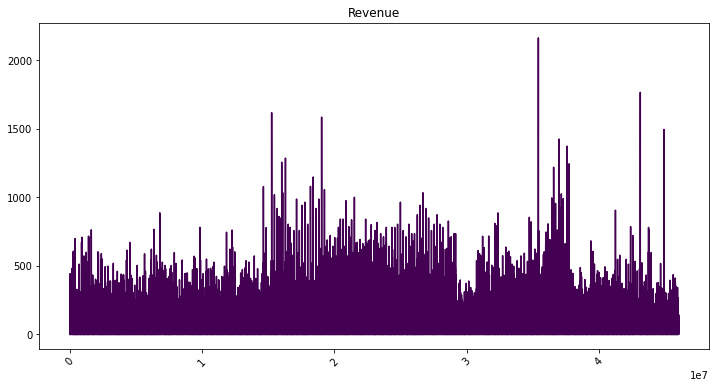

In [114]:
sales_prices['revenue'].plot(figsize=(12,6), rot=45, cmap='viridis')
plt.title('Revenue')
plt.show()